**This example demonstrates the prediction of the product tier of cars sold on a website from the information contained in the columns of the data 'Items_Cars_Data.csv'. 
The file 'Data_description.csv' describes the columns.**

**The notebook was created by Randa Natras: randa.natras@thotmail.com**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

# **Load data**

The data will be loaded into a pandas DataFrame, which are good tools for manipulating and displaying the data. Date columns are converted to datetime.

In [250]:
df = pd.read_csv ('Items_Cars_Data.csv', delimiter=';', parse_dates=["created_date", 'deleted_date'], dayfirst=True)

In [ ]:
description = pd.read_csv ('Data_Description.csv', delimiter=';')

In [ ]:
description

column name                                        description
0                article_id                          unique article identifier
1              product_tier                      premium status of the article
2                 make_name                       name of the car manufacturer
3                     price                               price of the article
4           first_zip_digit  first digit of the zip code of the region the ...
5   first_registration_year      year of the first registration of the article
6              created_date                       creation date of the listing
7              deleted_date                       deletion date of the listing
8              search_views  number of times the article has been shown as ...
9              detail_views    number of times the article has been clicked on
10               stock_days  Time in days between the creation of the listi...
11                      ctr  Click through rate calculated as the quotient ...

# **Examine data**

It's good practice to check the data first to get better understanding of data.

In [ ]:
df

article_id product_tier      make_name  price  first_zip_digit  \
0       350625839        Basic     Mitsubishi  16750                5   
1       354412280        Basic  Mercedes-Benz  35950                4   
2       349572992        Basic  Mercedes-Benz  11950                3   
3       350266763        Basic           Ford   1750                6   
4       355688985        Basic  Mercedes-Benz  26500                3   
...           ...          ...            ...    ...              ...   
78265   364276155        Basic            BMW   7950                4   
78266   354422963        Basic        Citroen   5425                1   
78267   361201591      Premium          Mazda   1444                5   
78268   353637799        Basic           Fiat   7840                5   
78269   353006120        Basic           Opel   2399                3   

       first_registration_year created_date deleted_date  search_views  \
0                         2013   2018-07-24   2018-08-24        3091.0   
1                         2015   2018-08-16   2018-10-07        3283.0   
2                         1998   2018-07-16   2018-09-05        3247.0   
3                         2003   2018-07-20   2018-10-29        1856.0   
4                         2014   2018-08-28   2018-09-08         490.0   
...                        ...          ...          ...           ...   
78265                     2005   2018-11-24   2019-01-31        5254.0   
78266                     2012   2018-08-16   2018-08-31         330.0   
78267                     2005   2018-10-20   2018-10-27       10731.0   
78268                     2014   2018-08-08   2018-12-12        1106.0   
78269                     2008   2018-08-04   2018-11-12       27609.0   

       detail_views  stock_days          ctr  
0             123.0          30    0.0378033  
1             223.0          52  0.067925678  
2             265.0          51  0.081613797  
3              26.0         101  0.014008621  
4              20.0          12  0.040816327  
...             ...         ...          ...  
78265         251.0          68  0.047773125  
78266          27.0          15  0.081818182  
78267         495.0           8   0.04612804  
78268           8.0         126  0.007233273  
78269        2240.0          99  0.081132964  

[78270 rows x 12 columns]

In [ ]:
#Check the data type of each column
df.dtypes

article_id                          int64
product_tier                       object
make_name                          object
price                               int64
first_zip_digit                     int64
first_registration_year             int64
created_date               datetime64[ns]
deleted_date               datetime64[ns]
search_views                      float64
detail_views                      float64
stock_days                          int64
ctr                                object
dtype: object

In [ ]:
# See the column data types and non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78270 entries, 0 to 78269
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   article_id               78270 non-null  int64         
 1   product_tier             78270 non-null  object        
 2   make_name                78270 non-null  object        
 3   price                    78270 non-null  int64         
 4   first_zip_digit          78270 non-null  int64         
 5   first_registration_year  78270 non-null  int64         
 6   created_date             78270 non-null  datetime64[ns]
 7   deleted_date             78270 non-null  datetime64[ns]
 8   search_views             78260 non-null  float64       
 9   detail_views             78260 non-null  float64       
 10  stock_days               78270 non-null  int64         
 11  ctr                      78246 non-null  object        
dtypes: datetime64[ns](2), float64(2)

From the first data check, the data frame has 11 columns and 38862 rows.
The object columns include a total of 3 columns, of which two columns represent product_tier and make_name, and third one ctr was calculated from two numeric columns, as described in the file "Data_Description.csv". 
Total numerical (int64 and float64) columns are 7, and two columns are datetime64 type.

In [ ]:
#check if there are missing values
df.isna().sum()

article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64

 Columns 'search_views', 'detail_views', and 'ctr' contain missing values. The missing data need to be handle as many machine learning algorithms do not support missing values. Let's first check where the missing values are.

In [ ]:
np.where(df['search_views'].isnull() == True)[0]

array([10151, 21423, 27830, 47864, 57347, 60752, 63571, 65121, 66492,
       72388])

In [ ]:
np.where(df['detail_views'].isnull() == True)[0]

array([10151, 21423, 27830, 47864, 57347, 60752, 63571, 65121, 66492,
       72388])

In [ ]:
np.where(df['ctr'].isnull() == True)[0]

array([ 6738, 10151, 19983, 21423, 26122, 27830, 28823, 38923, 43222,
       47864, 52285, 57347, 60752, 63571, 65121, 66492, 68578, 69156,
       70752, 71063, 71834, 72388, 72600, 78029])

There are 10 missing values in search_views and detail_view at the same locations, and 24 missing values in ctr, 10 of which overlap with the location of the missing values in the previously mentioned columns, i.e. locations [10151, 21423, 27830, 47864, 57347, 60752, 63571, 65121, 66492, 72388]. Let's now check the first 10 rows with the missing values in 'ctr'.

In [ ]:
display(df[6738:6739])
display(df[10151:10152])
display(df[19983:19984])
display(df[21423:21424])
display(df[26122:26123])
display(df[27830:27831])
display(df[28823:28824])
display(df[38923:38924])
display(df[43222:43223])
display(df[47864:47865])

article_id product_tier make_name  price  first_zip_digit  \
6738   355684985        Basic     Volvo   5950                8   

      first_registration_year created_date deleted_date  search_views  \
6738                     2009   2018-08-28   2018-08-28           0.0   

      detail_views  stock_days  ctr  
6738           0.0           0  NaN

article_id product_tier make_name  price  first_zip_digit  \
10151   363161664        Basic   Renault   4950                3   

       first_registration_year created_date deleted_date  search_views  \
10151                     2011   2018-11-12   2019-03-01           NaN   

       detail_views  stock_days  ctr  
10151           NaN         109  NaN

article_id product_tier      make_name  price  first_zip_digit  \
19983   360460901        Basic  Mercedes-Benz    105                7   

       first_registration_year created_date deleted_date  search_views  \
19983                     2004   2018-10-12   2018-10-12           0.0   

       detail_views  stock_days  ctr  
19983           0.0          -1  NaN

article_id product_tier   make_name  price  first_zip_digit  \
21423   358837372        Basic  Volkswagen   2999                5   

       first_registration_year created_date deleted_date  search_views  \
21423                     2003   2018-09-24   2018-09-24           NaN   

       detail_views  stock_days  ctr  
21423           NaN           0  NaN

article_id product_tier      make_name  price  first_zip_digit  \
26122   360460897        Basic  Mercedes-Benz  22445                7   

       first_registration_year created_date deleted_date  search_views  \
26122                     2011   2018-10-12   2018-10-12           0.0   

       detail_views  stock_days  ctr  
26122           0.0           0  NaN

article_id product_tier   make_name  price  first_zip_digit  \
27830   358837359        Basic  Volkswagen   2999                5   

       first_registration_year created_date deleted_date  search_views  \
27830                     2003   2018-09-24   2018-09-24           NaN   

       detail_views  stock_days  ctr  
27830           NaN           0  NaN

article_id product_tier      make_name  price  first_zip_digit  \
28823   360460890        Basic  Mercedes-Benz  26445                7   

       first_registration_year created_date deleted_date  search_views  \
28823                     2011   2018-10-12   2018-10-12           0.0   

       detail_views  stock_days  ctr  
28823           0.0           0  NaN

article_id product_tier make_name  price  first_zip_digit  \
38923   360471136        Basic      Audi   1500                2   

       first_registration_year created_date deleted_date  search_views  \
38923                     2012   2018-10-12   2018-10-12           0.0   

       detail_views  stock_days  ctr  
38923           0.0           0  NaN

article_id product_tier      make_name  price  first_zip_digit  \
43222   360493605        Basic  Mercedes-Benz  37500                3   

       first_registration_year created_date deleted_date  search_views  \
43222                     2002   2018-10-12   2018-10-12           0.0   

       detail_views  stock_days  ctr  
43222           0.0           0  NaN

article_id product_tier   make_name  price  first_zip_digit  \
47864   358837344        Basic  Volkswagen   2999                5   

       first_registration_year created_date deleted_date  search_views  \
47864                     2003   2018-09-24   2018-09-24           NaN   

       detail_views  stock_days  ctr  
47864           NaN           0  NaN

There is clearly overlap of missing values for all 3 columns (search_views, detail_views, ctr), but ctr column has extra number of missing values. Due to the overlap of missing values in search_views and detail_views with ctr, or 0 values in search_views and detail_views, we cannot use search_views and detail_views to impute ctr here, or vice versa. Some rows have 0 search_views and 0 detail_views, where the stock days are 0 or negative. This may mean that the article was deleted shortly after it was created. I assume that these rows are not so important and meaningful for prediction, since the article was quickly deleted without being viewed, and there are only a few such cases. 

Imputing values for search_views and detail_views is a bit challenging, as they depend on the number of users, searches and clicks. Therefore, imputation using methods such as forward or backward filling is not suitable here. Another possible approach could be to try to predict these values using the other columns/features. However, those predicted values would be only a proxy for the true values. 

The dataset has in total 78270 rows. Deleting 24 rows should not have much affect to the result comparing to the length of the complete dataset. Therefore, the rows with missing values will be removed in the next step.

In [251]:
#deleting rows with missing values
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.isna().sum()

article_id                 0
product_tier               0
make_name                  0
price                      0
first_zip_digit            0
first_registration_year    0
created_date               0
deleted_date               0
search_views               0
detail_views               0
stock_days                 0
ctr                        0
dtype: int64

Moreover, when checking the data, the error value in ctr is found in the row 849. Therefore it is better to recalculate the column.

In [ ]:
#27.624.309.392.265.100 is error value, it should be 0.27624309392265100 
df[849:850]

article_id product_tier   make_name  price  first_zip_digit  \
849   361161145        Basic  Volkswagen  32450                6   

     first_registration_year created_date deleted_date  search_views  \
849                     2018   2018-10-20   2018-11-08        2172.0   

     detail_views  stock_days                     ctr  
849          60.0          19  27.624.309.392.265.100

In [252]:
#because of the problems with values, I will re-calculate again 'ctr' column as the quotient of detail_views over search_views
df['ctr']=df['detail_views'] / df['search_views']

In [ ]:
df

article_id product_tier      make_name  price  first_zip_digit  \
0       350625839        Basic     Mitsubishi  16750                5   
1       354412280        Basic  Mercedes-Benz  35950                4   
2       349572992        Basic  Mercedes-Benz  11950                3   
3       350266763        Basic           Ford   1750                6   
4       355688985        Basic  Mercedes-Benz  26500                3   
...           ...          ...            ...    ...              ...   
78241   364276155        Basic            BMW   7950                4   
78242   354422963        Basic        Citroen   5425                1   
78243   361201591      Premium          Mazda   1444                5   
78244   353637799        Basic           Fiat   7840                5   
78245   353006120        Basic           Opel   2399                3   

       first_registration_year created_date deleted_date  search_views  \
0                         2013   2018-07-24   2018-08-24        3091.0   
1                         2015   2018-08-16   2018-10-07        3283.0   
2                         1998   2018-07-16   2018-09-05        3247.0   
3                         2003   2018-07-20   2018-10-29        1856.0   
4                         2014   2018-08-28   2018-09-08         490.0   
...                        ...          ...          ...           ...   
78241                     2005   2018-11-24   2019-01-31        5254.0   
78242                     2012   2018-08-16   2018-08-31         330.0   
78243                     2005   2018-10-20   2018-10-27       10731.0   
78244                     2014   2018-08-08   2018-12-12        1106.0   
78245                     2008   2018-08-04   2018-11-12       27609.0   

       detail_views  stock_days       ctr  
0             123.0          30  0.039793  
1             223.0          52  0.067926  
2             265.0          51  0.081614  
3              26.0         101  0.014009  
4              20.0          12  0.040816  
...             ...         ...       ...  
78241         251.0          68  0.047773  
78242          27.0          15  0.081818  
78243         495.0           8  0.046128  
78244           8.0         126  0.007233  
78245        2240.0          99  0.081133  

[78246 rows x 12 columns]

Looking at previous df table it can be noticed that some values are slightly different in ctr column, e.g. row 1, 78291, 78294. So it was good to recalculate the ctr column.

## **Deriving new features**

We can create new features from time information, for example, the age of cars.

In [253]:
#extract year
df['created_year'] = pd.DatetimeIndex(df['created_date']).year

In [254]:
df['age'] = df ['created_year'] - df ['first_registration_year']

In [255]:
df.head()

article_id product_tier      make_name  price  first_zip_digit  \
0   350625839        Basic     Mitsubishi  16750                5   
1   354412280        Basic  Mercedes-Benz  35950                4   
2   349572992        Basic  Mercedes-Benz  11950                3   
3   350266763        Basic           Ford   1750                6   
4   355688985        Basic  Mercedes-Benz  26500                3   

   first_registration_year created_date deleted_date  search_views  \
0                     2013   2018-07-24   2018-08-24        3091.0   
1                     2015   2018-08-16   2018-10-07        3283.0   
2                     1998   2018-07-16   2018-09-05        3247.0   
3                     2003   2018-07-20   2018-10-29        1856.0   
4                     2014   2018-08-28   2018-09-08         490.0   

   detail_views  stock_days       ctr  created_year  age  
0         123.0          30  0.039793          2018    5  
1         223.0          52  0.067926          2018    3  
2         265.0          51  0.081614          2018   20  
3          26.0         101  0.014009          2018   15  
4          20.0          12  0.040816          2018    4

# **Data exploratory analysis**

Now I will perform data exploratory analysis in order to better understand the data, to discover patterns, to spot anomalies and to check assumptions with the help of statistic summary and graphical representations.

Statistical summary

In [256]:
#Descriptive statistics
df.describe()

article_id          price  first_zip_digit  first_registration_year  \
count  7.824600e+04   78246.000000     78246.000000             78246.000000   
mean   3.574863e+08   15070.682412         4.631381              2011.090573   
std    5.076876e+06   16377.089474         2.354300                 6.538797   
min    3.472324e+08      50.000000         1.000000              1924.000000   
25%    3.536387e+08    5750.000000         3.000000              2008.000000   
50%    3.585479e+08   10916.500000         5.000000              2013.000000   
75%    3.614817e+08   18890.000000         7.000000              2015.000000   
max    3.647040e+08  249888.000000         9.000000              2106.000000   

        search_views  detail_views    stock_days           ctr  created_year  \
count   78246.000000  78246.000000  78246.000000  78246.000000       78246.0   
mean     2298.450477     93.503527     35.999105      0.046891        2018.0   
std      6341.363461    228.095443     32.214741      0.038822           0.0   
min         1.000000      0.000000     -3.000000      0.000000        2018.0   
25%       368.000000     13.000000     10.000000      0.024261        2018.0   
50%       920.000000     36.000000     25.000000      0.038237        2018.0   
75%      2234.000000     94.000000     55.000000      0.058679        2018.0   
max    608754.000000  13926.000000    127.000000      1.833333        2018.0   

                age  
count  78246.000000  
mean       6.909427  
std        6.538797  
min      -88.000000  
25%        3.000000  
50%        5.000000  
75%       10.000000  
max       94.000000

Numerical data: The distribution for search_views and detail_views looks skewed as mean and median (50%) are not close. Also the maximum value for first_registration_year and the minimum value fo age look anomalous, which will be checked later by plots.

In [ ]:
categ = ['product_tier','make_name']

In [ ]:
df[categ].describe()

product_tier   make_name
count         78246       78246
unique            3          91
top           Basic  Volkswagen
freq          75347        9420

Categorical data: The data in product_tier has 3 unique values with the most common value being "Basic". The data in make_name has 91 unique values with the most common value being "Volkswagen".

Let's plot column product_tier.

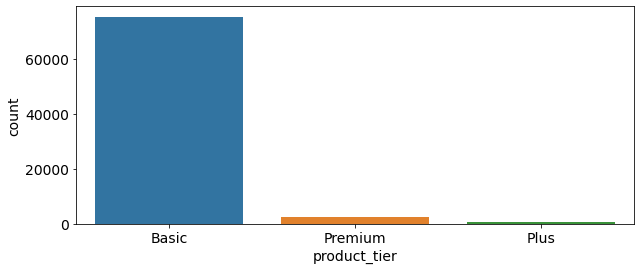

In [ ]:
sns.countplot(x="product_tier", data = df)
plt.rcParams ['figure.figsize'] =  [10,4]
plt.rcParams.update({'font.size': 14})

The majority of products are Basic Tier, while Premium and Plus Tier are in the minority. A strong imbalance between the classes can be observed. This can pose a difficulty for a learning algorithm, leading to a biased model for the
majority of cases. With imbalanced data, a machine learning model can achieve high accuracy by predicting only the majority class but not capturing the minority class. Therefore, it is important to consider how to deal with an unbalanced data set. Possible solutions for dealing with imbalanced data include selecting appropriate learning algorithms (e.g., tree-based algorithms and boosting may be more appropriate), training on undersampled or oversampled datasets, generating synthetic data for the minority class, using cost-sensitive solutions that adjust the penalty to the degree of importance assigned to the minority class to penalize errors in the minority class. It is also important to choose an appropriate performance metric to evaluate a model with an imbalanced data set (e.g., confusion matrix, precision, recall, F1 score).

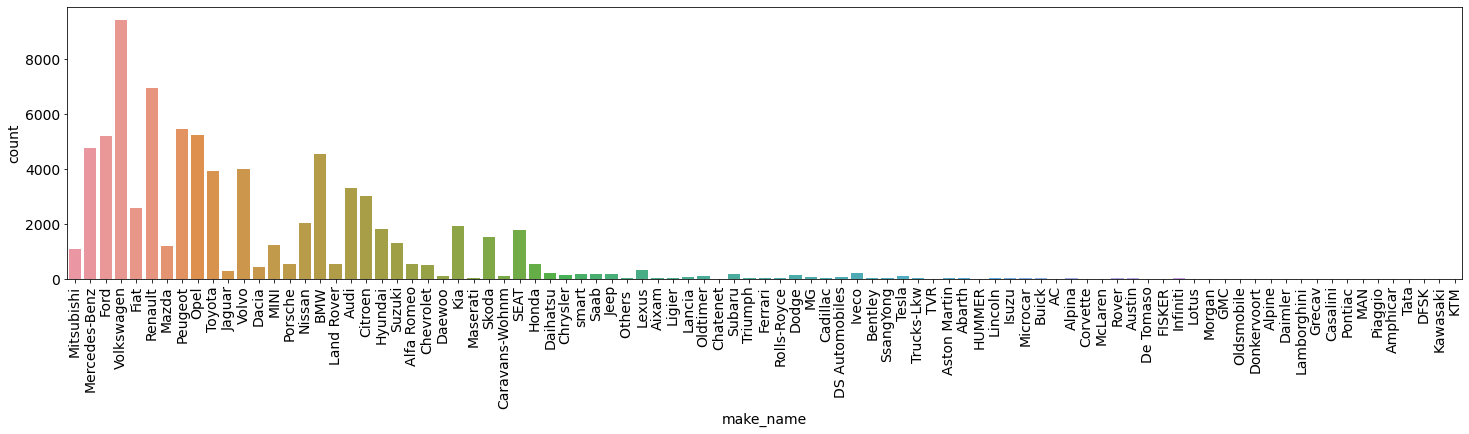

In [ ]:
sns.countplot(x="make_name", data = df)
plt.rcParams ['figure.figsize'] =  [25.0, 5]
plt.xticks(rotation=90)
plt.show()

The above diagram shows which cars are included in the data set. It can be seen that most of the cars are Volkswagen, Renault, Peugeot, Opel, Ford, Mercedes-Benz and BMW. On the right side of the diagram there are many other brands with a small number of products listed.

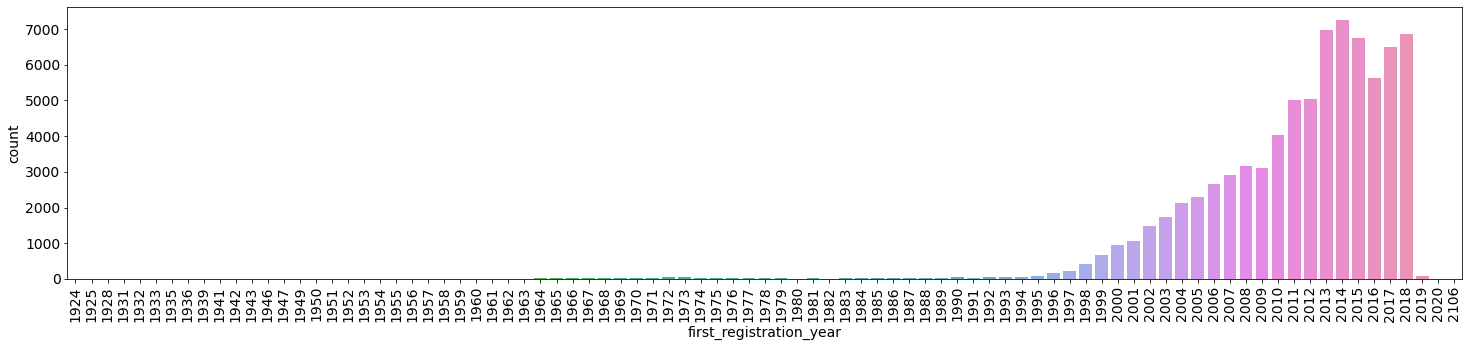

In [ ]:
sns.countplot(data = df, x="first_registration_year")
plt.xticks(rotation=90)
plt.show()

We see that the registration years are from 1924, but after 2000 we see a significant increase in the amount of data. Most items have a registration year between 2010 and 2018. Also, there is a value for first_registration_year "2106", which is an anomaly here. I suspect it should be 2016, but it might be  2006. This could be double checked to be sure what year it is. Since I cannot verify this, I will remove this row since it is only one. First I will check the problematic row.

In [ ]:
is_anomaly=(df['first_registration_year']==2106)
is_anomaly_index=df[is_anomaly].index
i=is_anomaly_index
print (i)

Int64Index([36295], dtype='int64')


In [ ]:
df[36295:36296]

article_id product_tier make_name  price  first_zip_digit  \
36295   358877131        Basic      Opel   9250                7   

       first_registration_year created_date deleted_date  search_views  \
36295                     2106   2018-09-24   2018-09-26         113.0   

       detail_views  stock_days       ctr  weekends_no  created_month  \
36295           5.0           2  0.044248          0.0              9   

       deleted_month  peak_season  
36295              9          1.0

In [ ]:
df[36295:36296]

article_id product_tier make_name  price  first_zip_digit  \
36295   358877131        Basic      Opel   9250                7   

       first_registration_year created_date deleted_date  search_views  \
36295                     2106   2018-09-24   2018-09-26         113.0   

       detail_views  stock_days       ctr  created_year  age  
36295           5.0           2  0.044248          2018  -88

In [ ]:
#remove row with outlier
df.drop([36295], inplace = True )
df.reset_index(drop=True, inplace=True)

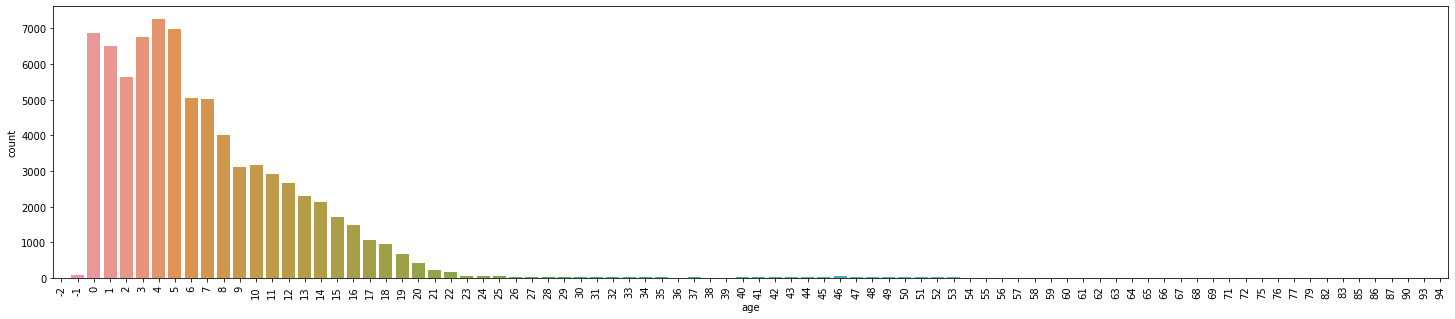

In [ ]:
sns.countplot(data = df, x="age")
plt.rcParams ['figure.figsize'] =  [25.0, 5]
plt.xticks(rotation=90)
plt.show()

The age goes up to 94, but the majority of cars are between 0 and 5 years, after which is a significant increase in the amount of cars sold on a website. Also, there is a value -1 and -2, which should be checked.

In [ ]:
is_age1=(df['age']==-1)
is_age2=(df['age']==-2)
is_age1_index=df[is_age1].index
is_age2_index=df[is_age2].index
i1=is_age1_index
i2=is_age2_index
print (i1)
print (i2)

Int64Index([  877,  1569,  4096,  4742,  6664,  6992,  7046,  7643, 12717,
            12942, 15311, 16020, 16600, 18508, 19020, 19371, 20480, 21558,
            22261, 26073, 26575, 27454, 27663, 27900, 31748, 32140, 32790,
            33299, 34288, 35352, 35592, 35686, 35916, 36218, 36989, 40532,
            41117, 41255, 41746, 41908, 43600, 46671, 48303, 49861, 50805,
            52917, 53337, 54483, 54917, 55784, 57376, 57701, 58114, 59275,
            60215, 60311, 61395, 62502, 64665, 64708, 64910, 66409, 67313,
            69945, 70607, 74103, 74347, 74518, 74541, 74870, 74975, 78108],
           dtype='int64')
Int64Index([77639], dtype='int64')


In [ ]:
display(df[12717:12718])
display(df[35352:35353])
display(df[64665:64666])

article_id product_tier make_name  price  first_zip_digit  \
12717   359257522        Basic      SEAT  25225                4   

       first_registration_year created_date deleted_date  search_views  \
12717                     2019   2018-09-28   2018-11-03         146.0   

       detail_views  stock_days  ctr  created_year  age  
12717           0.0          36  0.0          2018   -1

article_id product_tier make_name  price  first_zip_digit  \
35352   355477566        Basic     Skoda  38995                7   

       first_registration_year created_date deleted_date  search_views  \
35352                     2019   2018-08-24   2018-09-01          90.0   

       detail_views  stock_days  ctr  created_year  age  
35352           0.0           8  0.0          2018   -1

article_id product_tier make_name  price  first_zip_digit  \
64665   363589769        Basic      Ford  28400                7   

       first_registration_year created_date deleted_date  search_views  \
64665                     2019   2018-11-16   2019-01-17         409.0   

       detail_views  stock_days       ctr  created_year  age  
64665          25.0          62  0.061125          2018   -1

In [ ]:
df[77639:77640]

article_id product_tier      make_name  price  first_zip_digit  \
77639   359772338        Basic  Mercedes-Benz   1450                5   

       first_registration_year created_date deleted_date  search_views  \
77639                     2020   2018-10-04   2019-02-05      100439.0   

       detail_views  stock_days       ctr  created_year  age  
77639        3065.0         123  0.030516          2018   -2

There are cars that are registered only after they are taken from a website, that is, after they are sold.

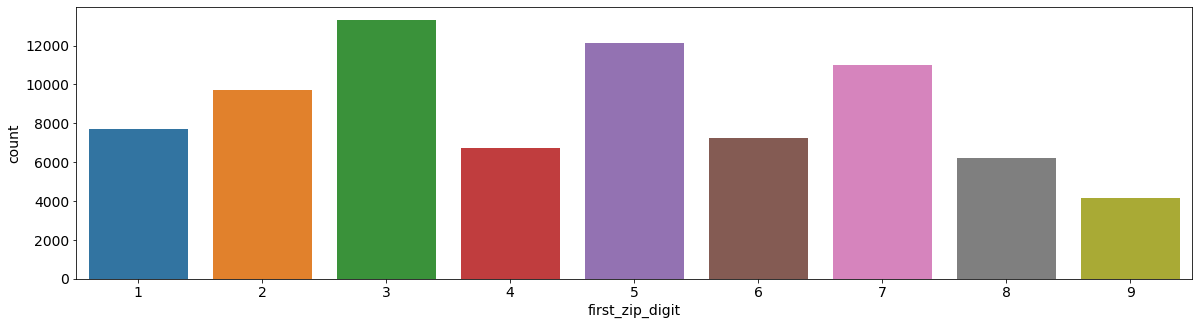

In [ ]:
sns.countplot(data = df, x='first_zip_digit')
plt.rcParams ['figure.figsize'] =  [20.0, 5]

Regarding the first digit of the zip code of the region the product is offered, it can be seen that the most items are offered in regions 3 and 5, while the smallest number of items is offered in region 9.

In [ ]:
numeric=['price', 'first_zip_digit', 'first_registration_year', 'age', 'search_views', 'detail_views', 'stock_days', 'ctr']

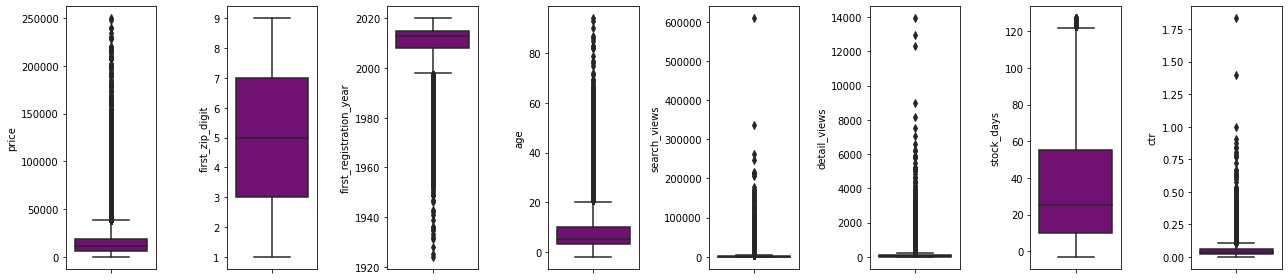

In [ ]:
features = numeric
plt.figure(figsize=(18, 4))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df[features[i]], color='purple',orient='v')
    plt.tight_layout();

In the boxplot graph can be seen that the price, first_registration_year, age, search_views, detail_views and ctr features have many outliers. Logarithmic (log) transformation can be used here to address skewed data effectively.

Several data columns are right skewed, except first_registration_year which is left skewed.


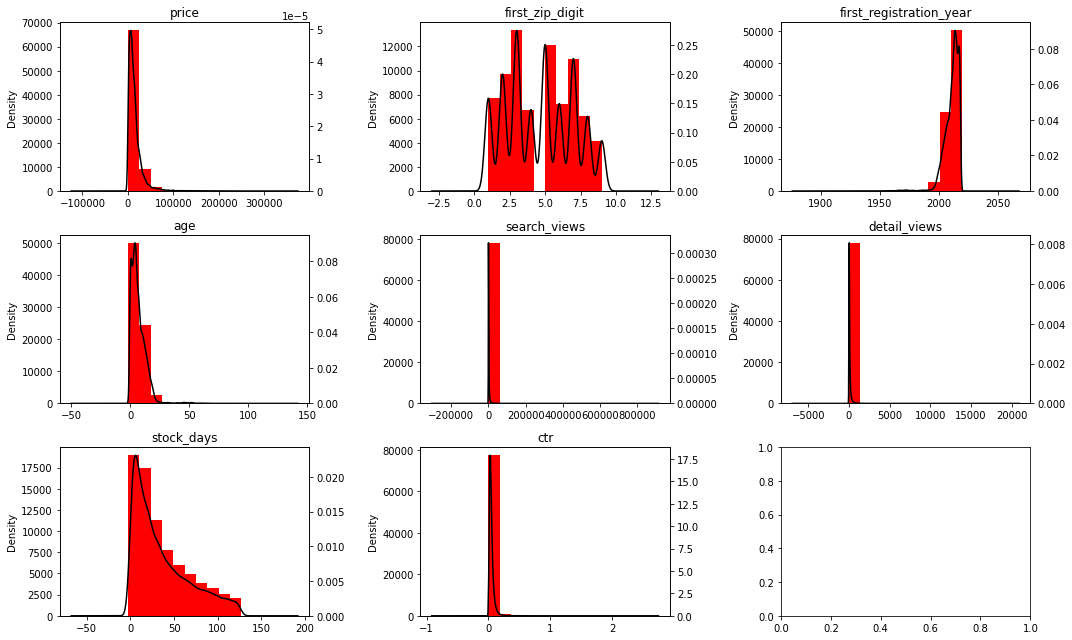

In [ ]:
#View data distribution
data_num = df[numeric]
k = len(data_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(data_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax, color='red')
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='black')
    ax2.set_ylim(0)
fig.tight_layout();

In [ ]:
#since detail_views and ctr have min values of 0, I used log(x+1) to avoid -inf values after transformation
#since 'age has min values of -2, I used log(x+3) to avoid -inf values after transformation
df_log=df.copy()
df_log['price'] = np.log10(df['price'])
df_log['first_registration_year'] = np.log10(df['first_registration_year'])
df_log['age'] = np.log10(df['age']+3)
df_log['search_views'] = np.log10(df['search_views']+1)
df_log['detail_views'] = np.log10(df['detail_views']+1)
df_log['ctr'] = np.log10(df['ctr']+1)

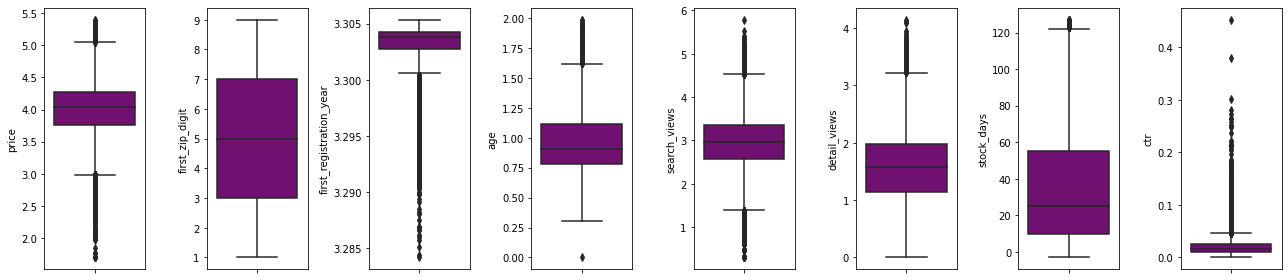

In [ ]:
#Features after logaritmic transformation
features = numeric
plt.figure(figsize=(18, 4))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df_log[features[i]], color='purple',orient='v')
    plt.tight_layout();

After log transformation, distribution of price, age, searc_views, detail_views corresponds better to normal distribution, while ctr and first_registration_year has still lot of outliers.

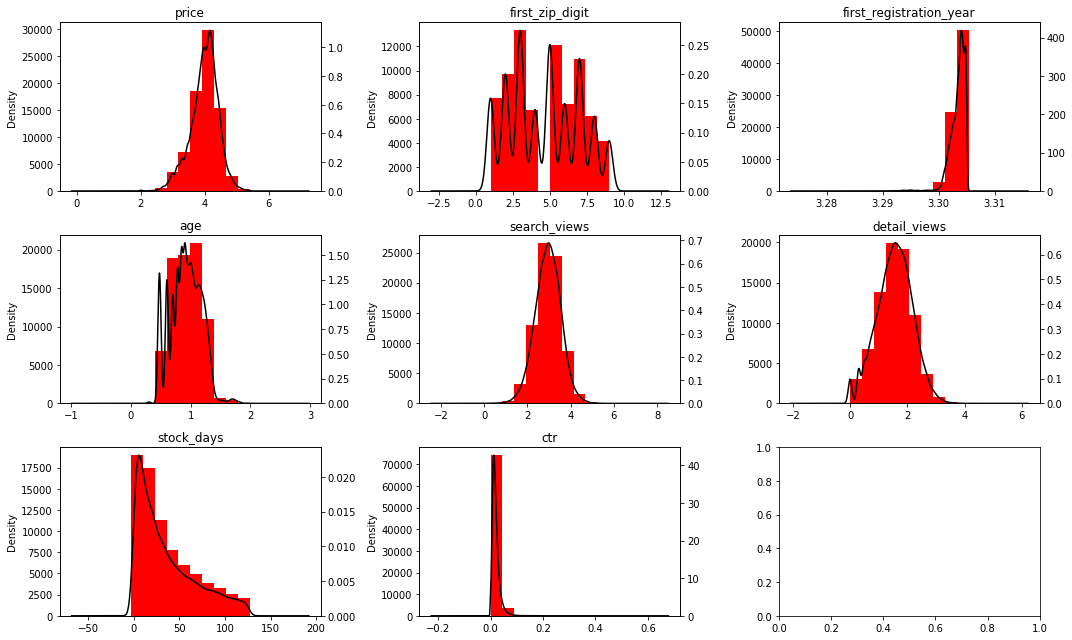

In [ ]:
#View data distribution with log transformation
data_num = df_log[numeric]
k = len(data_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(data_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax, color='red')
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='black')
    ax2.set_ylim(0)
fig.tight_layout();

Now we can create some scatter plots to see the relationships between the numeric variables in relation to the product tier categories.

<Figure size 864x360 with 0 Axes>

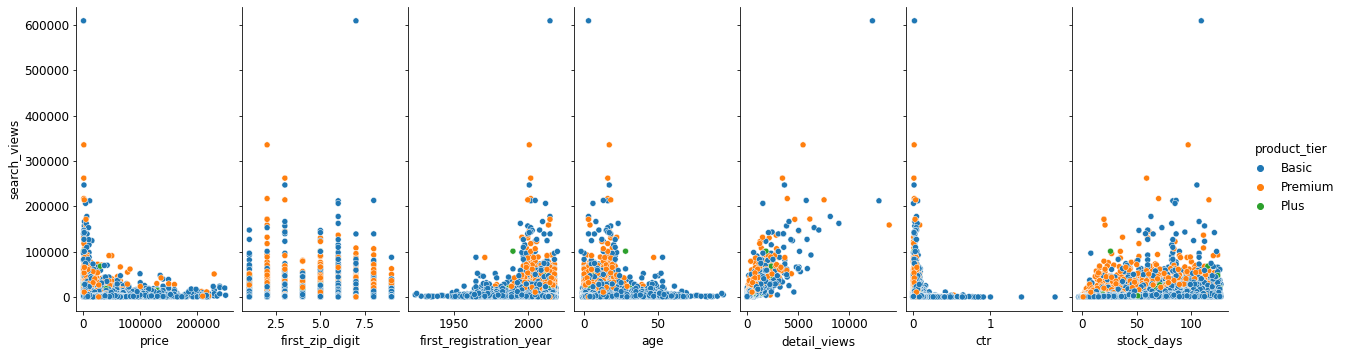

In [ ]:
#create a pairplot graph from each numeric data
plt.figure(figsize=(12,5))
sns.pairplot(data=df, 
             x_vars=['price','first_zip_digit','first_registration_year', 'age', 'detail_views','ctr', 'stock_days'], 
             y_vars=['search_views'], 
             hue ='product_tier',
             height=5, aspect=0.5);
fig.tight_layout();

<Figure size 864x360 with 0 Axes>

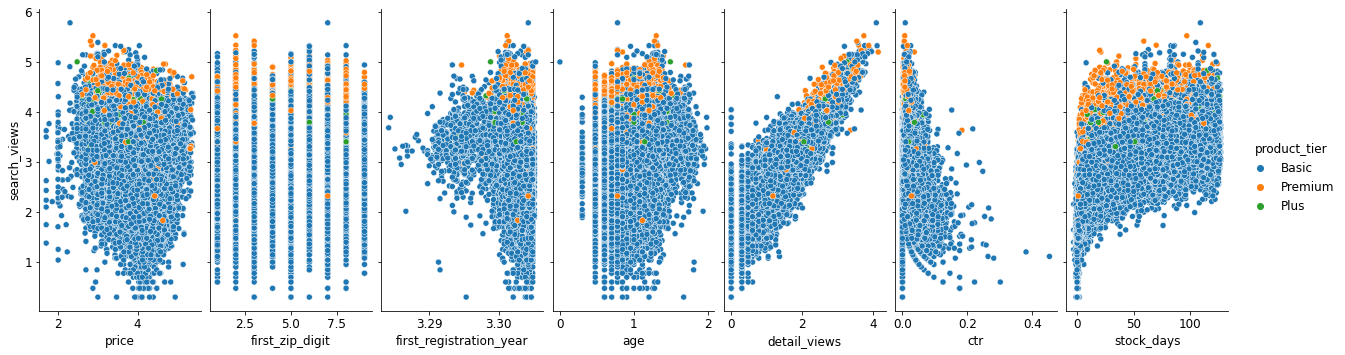

In [ ]:
#create a pairplot graph from each numeric data
plt.figure(figsize=(12,5))
sns.pairplot(data=df_log, 
             x_vars=['price','first_zip_digit','first_registration_year', 'age', 'detail_views','ctr', 'stock_days'], 
             y_vars=['search_views'], 
             hue ='product_tier',
             height=5, aspect=0.5);
fig.tight_layout();

The Basic product level has more searches, regardless of price or days in stock. 

In [ ]:
df_plot = df.drop(['article_id', 'make_name', 'created_date', 'deleted_date', 'created_year'], axis=1)

In [ ]:
df_log_plot = df_log.drop(['article_id', 'make_name', 'created_date', 'deleted_date', 'created_year'], axis=1)

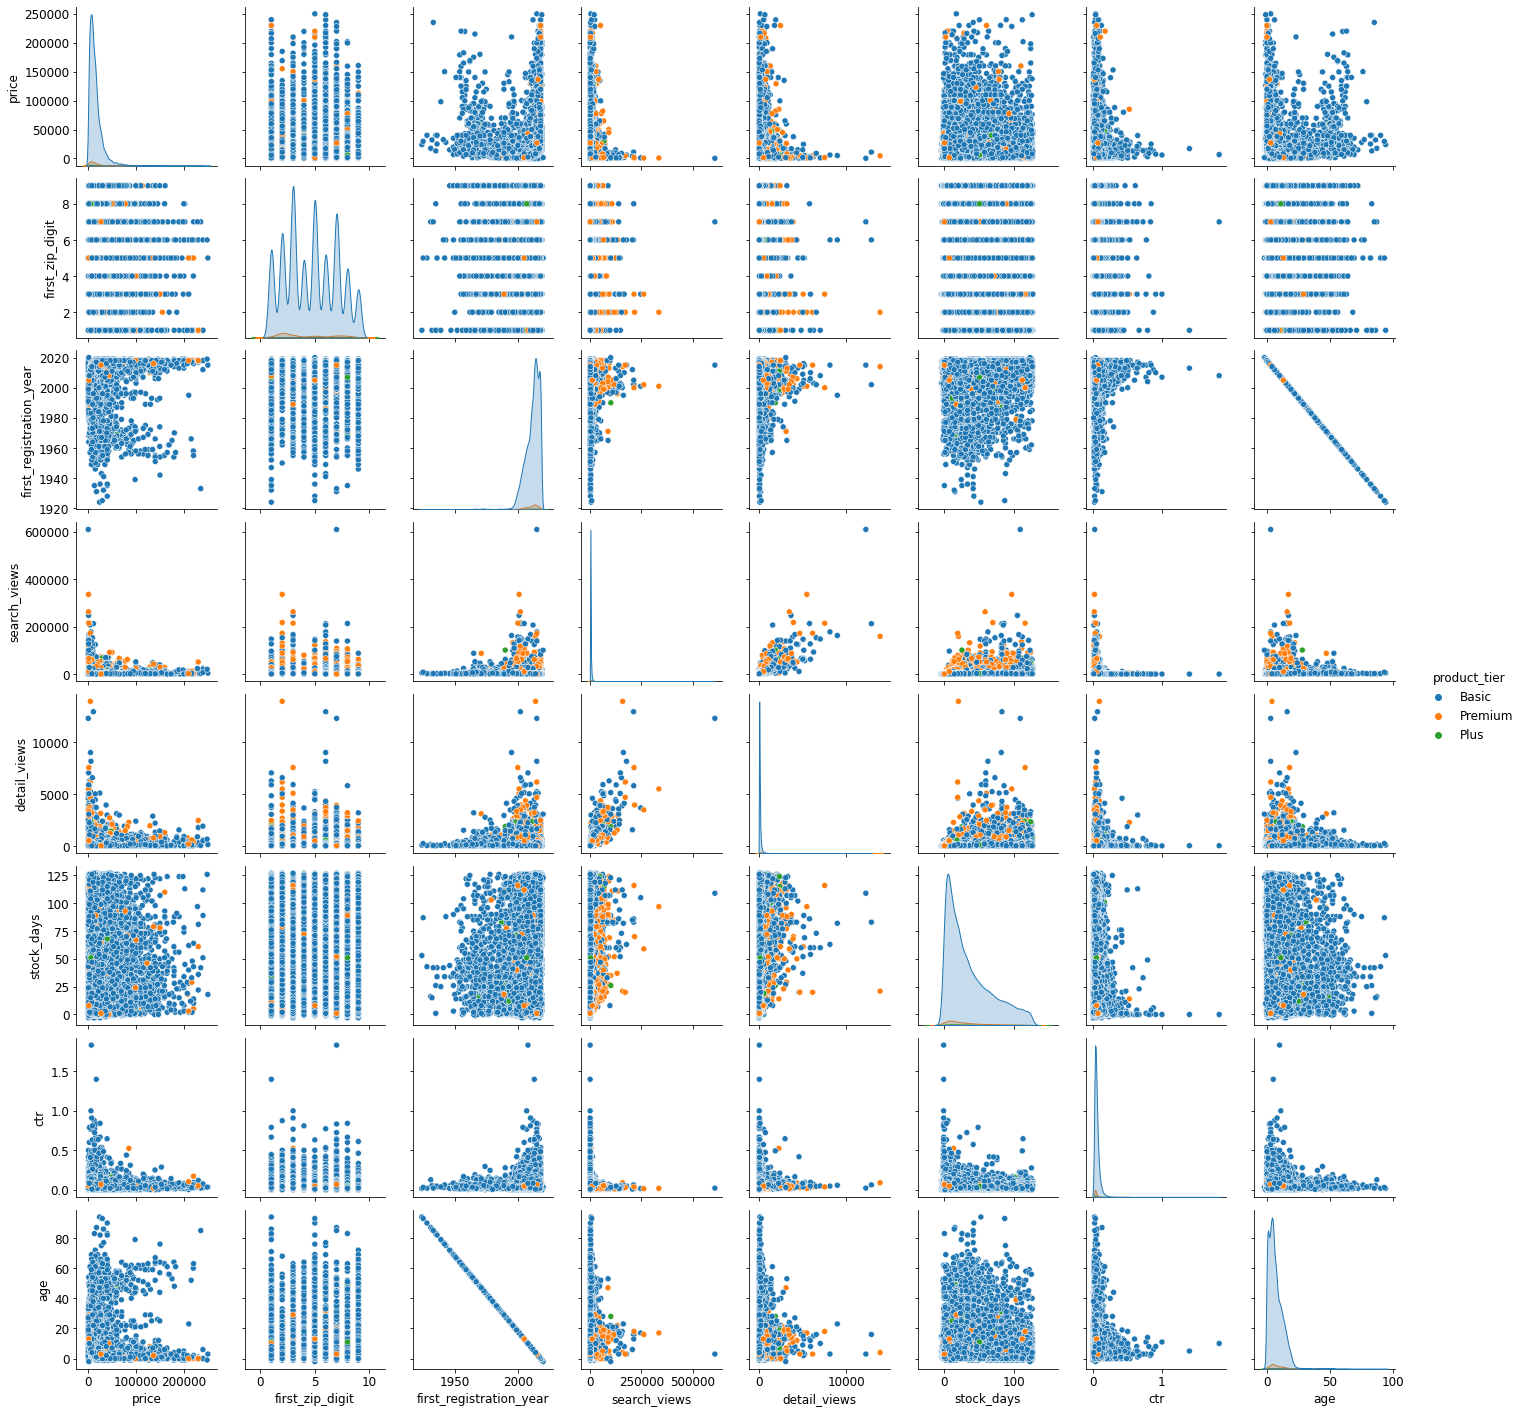

In [ ]:
sns.pairplot(df_plot, hue ='product_tier', palette="tab10")

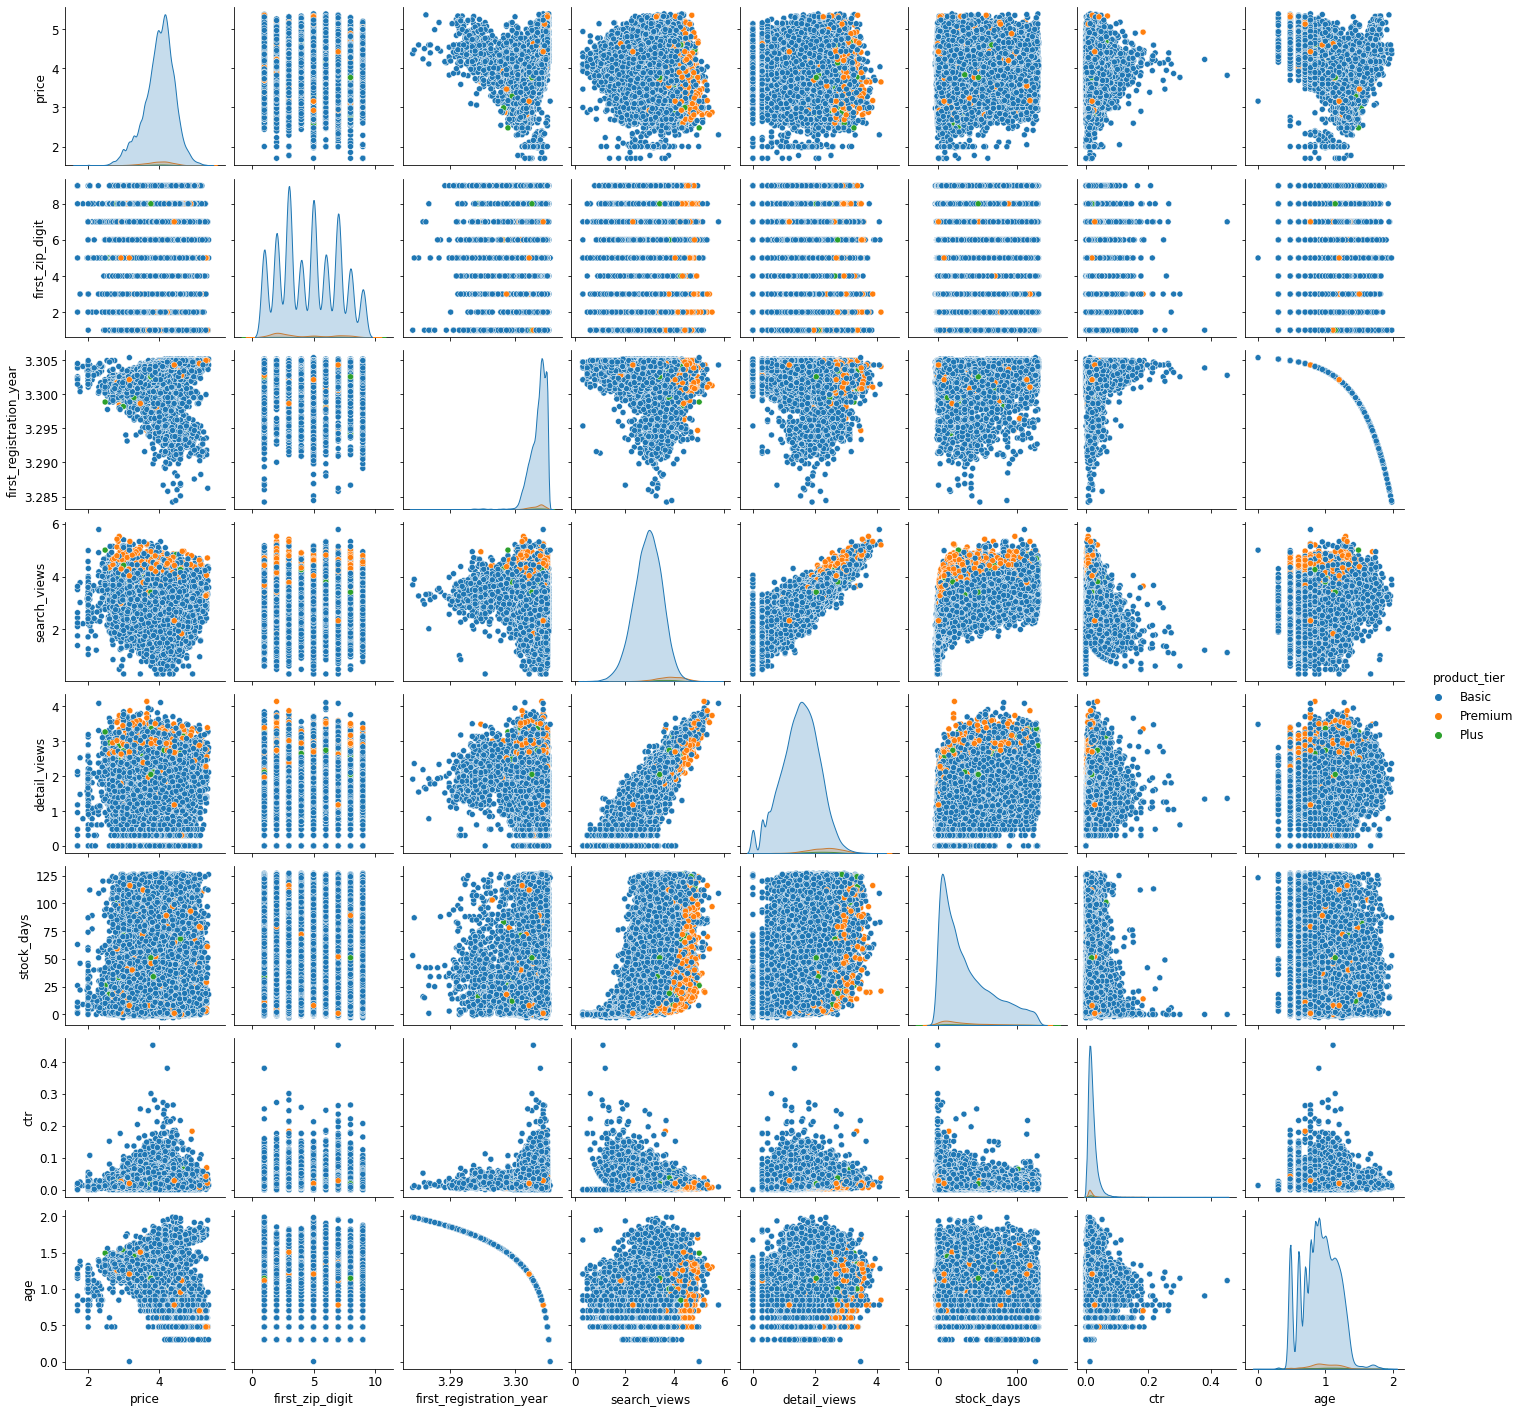

In [ ]:
sns.pairplot(df_log_plot, hue ='product_tier', palette="tab10")

Patterns between detail_views and first_zip_digit can be more clearly visible in the graph below.

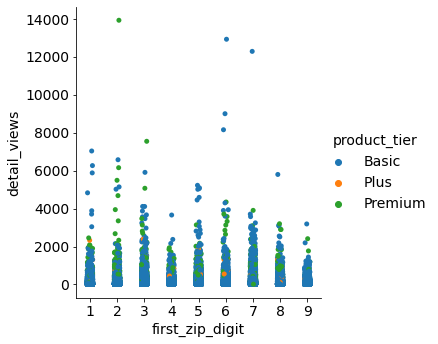

In [ ]:
sns.catplot(data=df, y='detail_views', x='first_zip_digit', hue='product_tier')

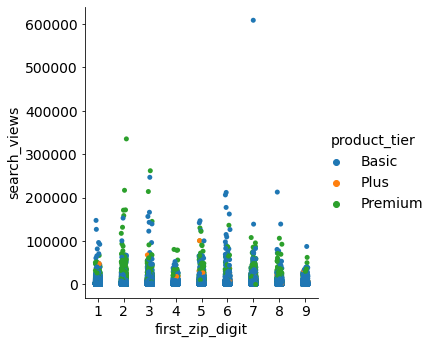

In [ ]:
sns.catplot(data=df, y='search_views', x='first_zip_digit', hue='product_tier')

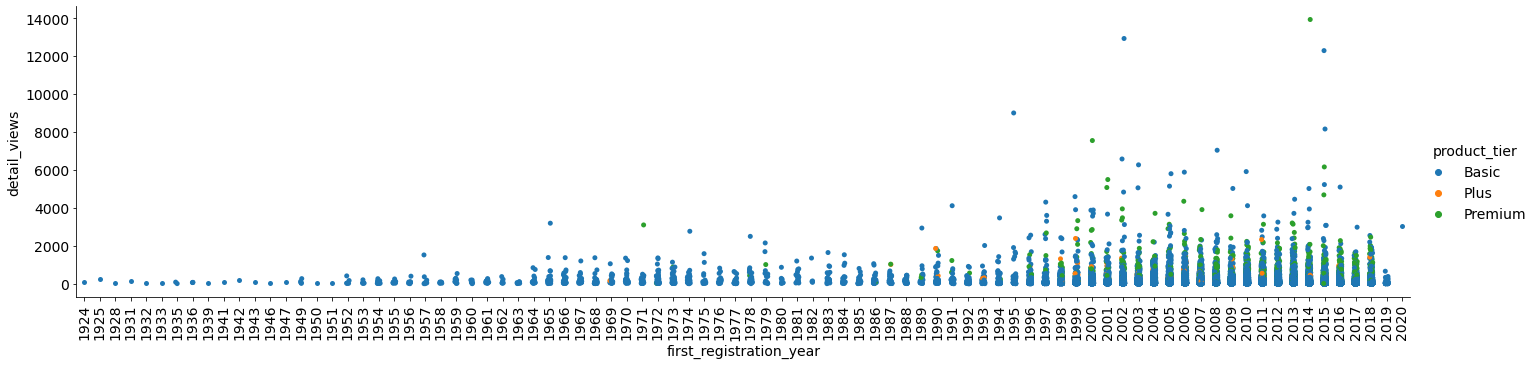

In [ ]:
sns.catplot(data=df, y='detail_views', x='first_registration_year', hue='product_tier', height=5, aspect=4)
plt.xticks(rotation=90)
plt.show()

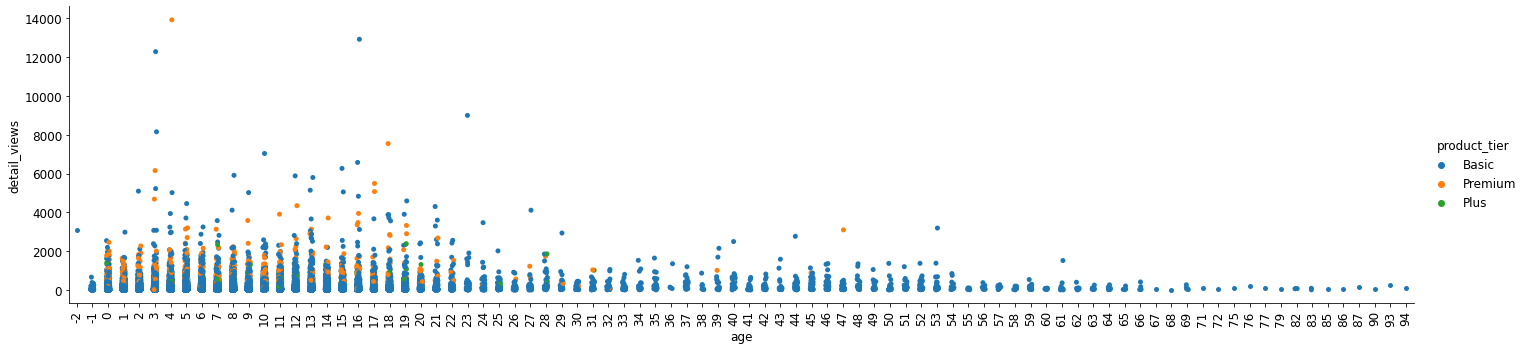

In [ ]:
sns.catplot(data=df, y='detail_views', x='age', hue='product_tier', height=5, aspect=4)
plt.xticks(rotation=90)
plt.show()

On the graph above it can be clearly seen that more detail_views apply to articles with registration_year from 2000 with the peak in 2014 and 2015, i.e. for the cars with registration 5-6 years old (relative to the last article offered in 2020).

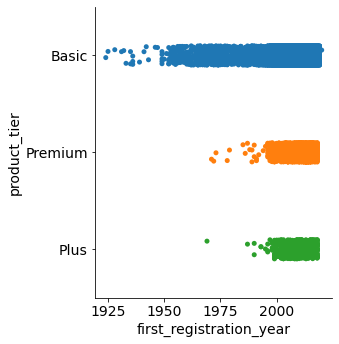

In [ ]:
sns.catplot(data=df,   y='product_tier', x='first_registration_year')

Basic articles have registration year from 1925, while Premium and Plus articles have newer registration year with the majority of articles from year 2000 onwards.

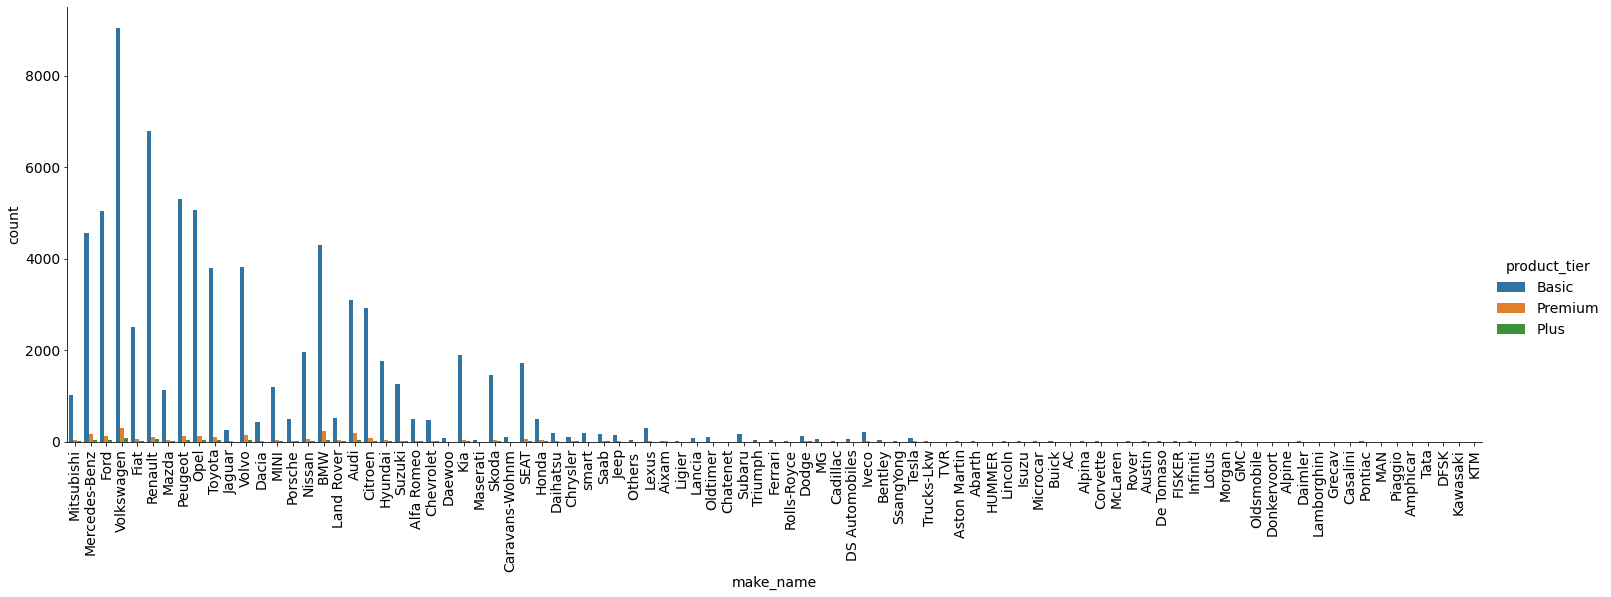

In [ ]:
sns.catplot( data = df, x='make_name', hue='product_tier', kind='count', height=7, aspect=3)
plt.xticks(rotation=90)
plt.show()

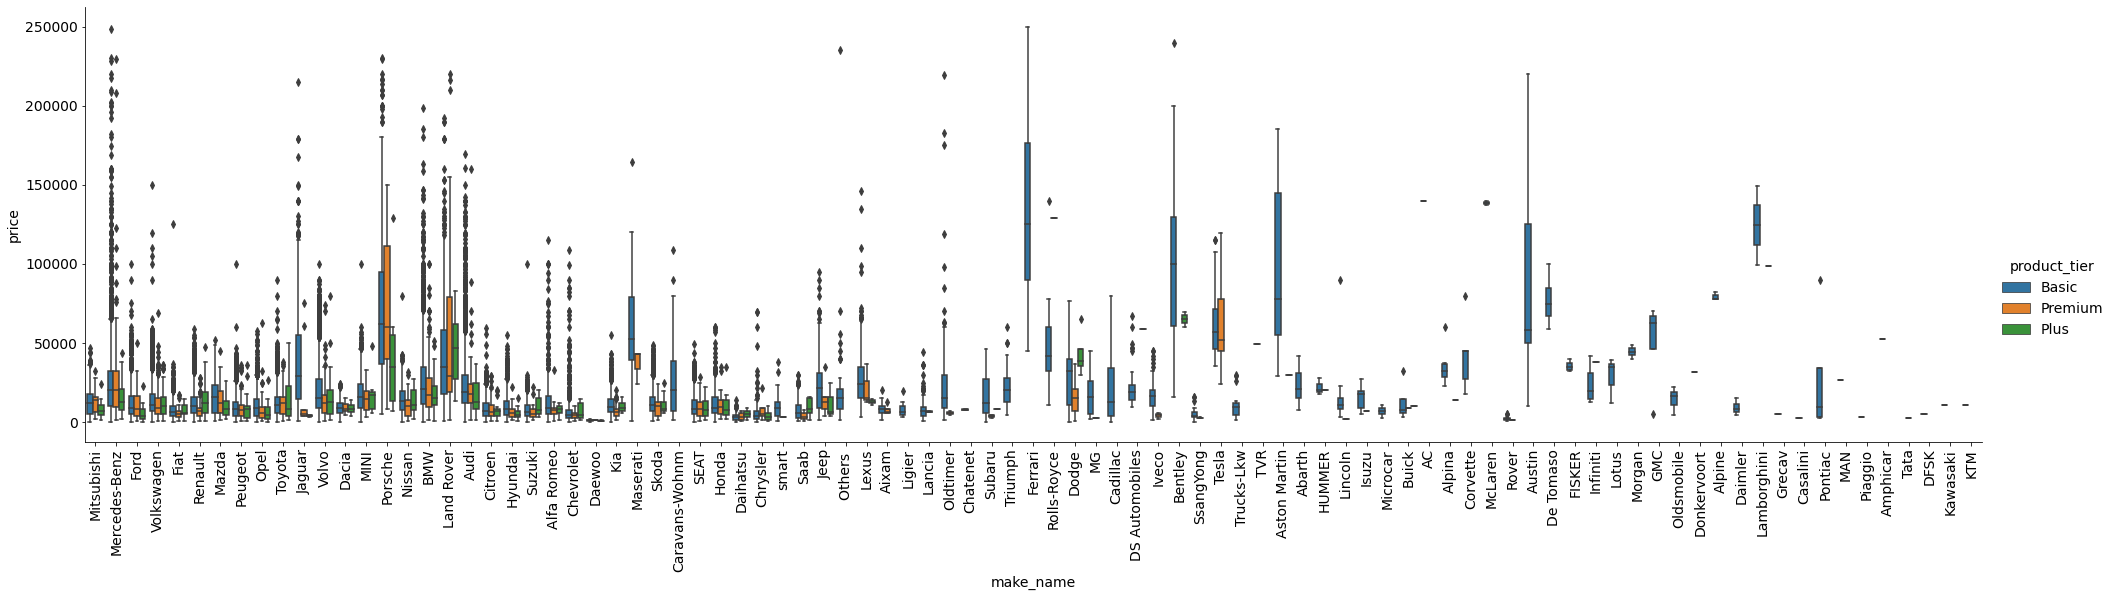

In [ ]:
sns.catplot( data = df, x='make_name', y='price', hue='product_tier', kind='box', height=7, aspect=4)
plt.xticks(rotation=90)
plt.show()

The graph above shows that Premium and Plus articles have sometimes larger price than Basic articles, for example Tesla, Land Rover, Porsche. The graph below shows that the overall prices between diffferent product_tier are not so much different for the majority of articles. All three product_tiers have otuliers, where the largest are for the Basic products and the smallest for the Plus articles.

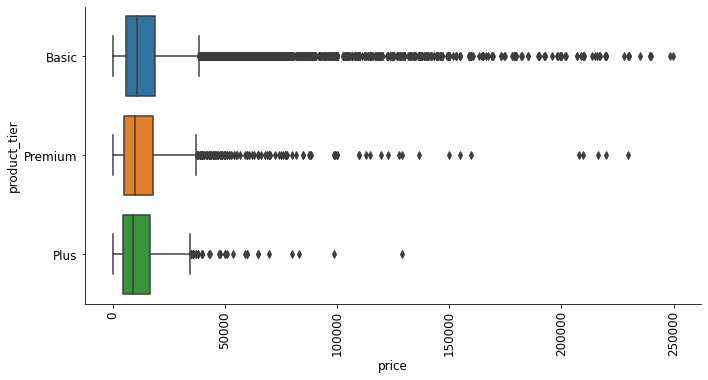

In [ ]:
sns.catplot( data = df, x='price', y='product_tier', kind='box', height=5, aspect=2)
plt.xticks(rotation=90)
plt.show()

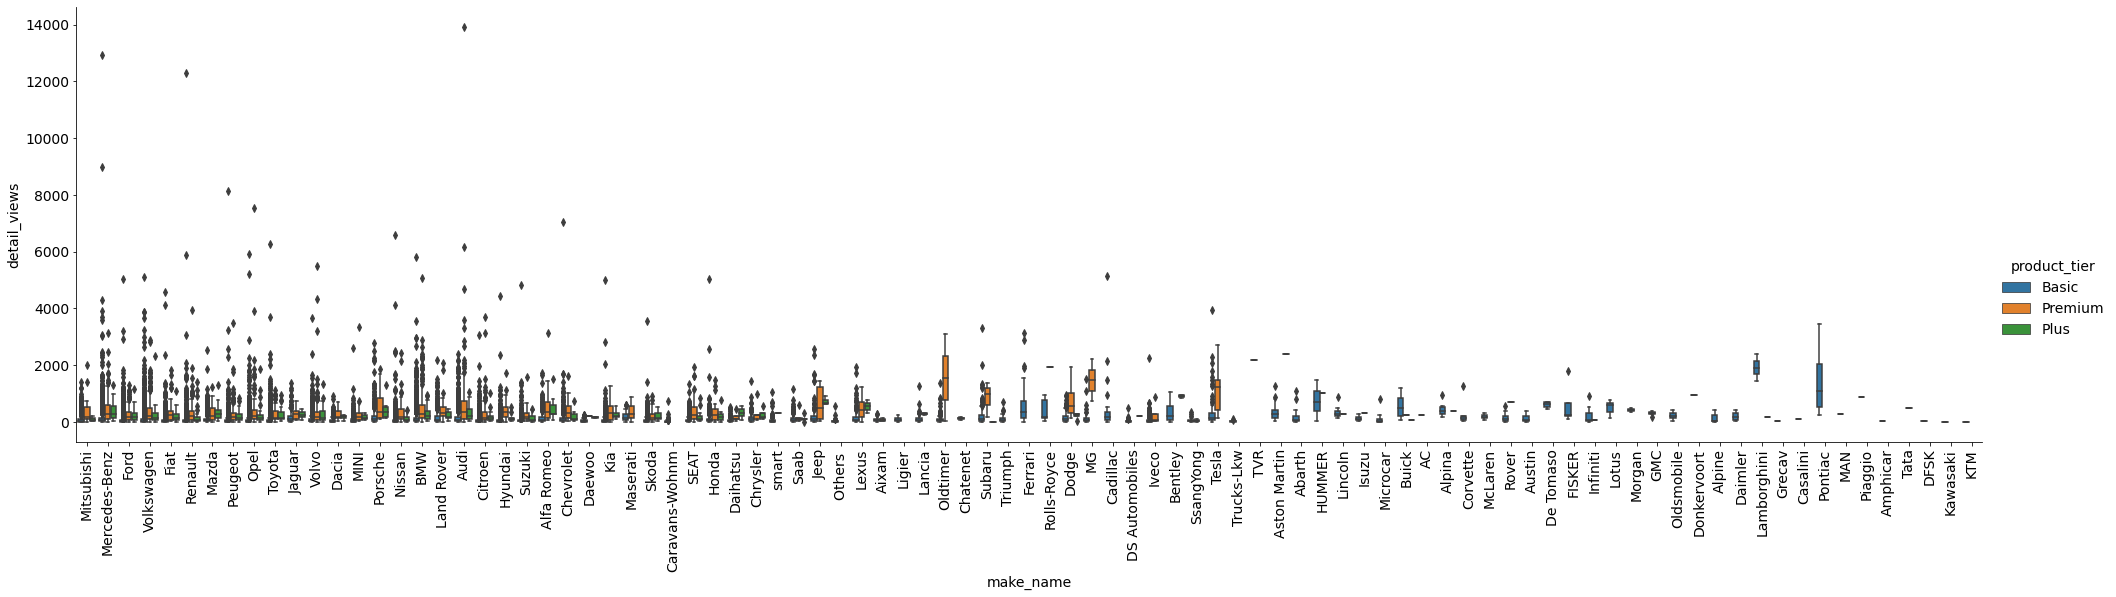

In [ ]:
sns.catplot( data = df, x='make_name', y='detail_views', hue='product_tier', kind='box', height=7, aspect=4)
plt.xticks(rotation=90)
plt.show()

On the graph above it can be seen that Premium type articles mostly have more detail_views, while Basic articles have larger outliers. This is also confirmed with the plot below, which showes larger median and maximum detail_views for the Premium and Plus articles.

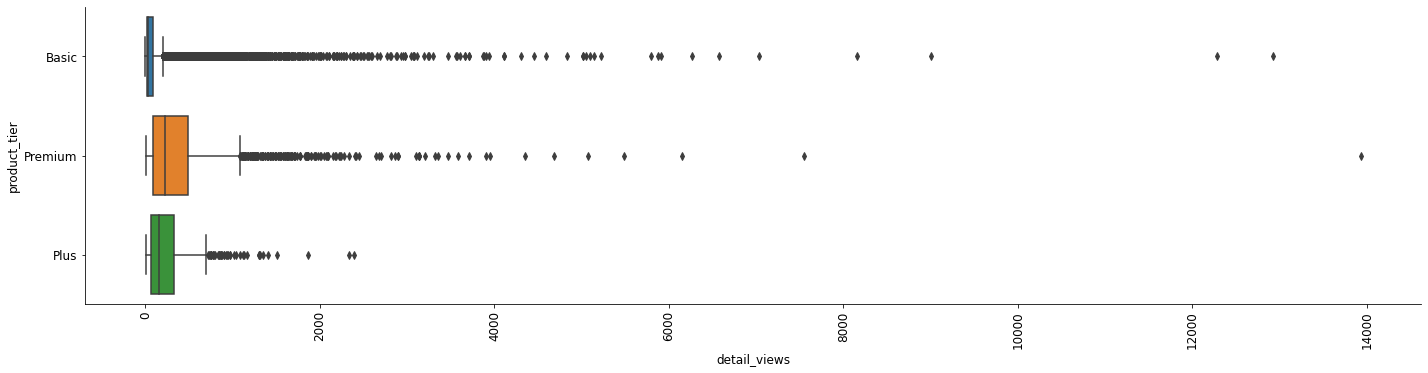

In [ ]:
sns.catplot( data = df, x='detail_views', y='product_tier', kind='box', height=5, aspect=4)
plt.xticks(rotation=90)
plt.show()

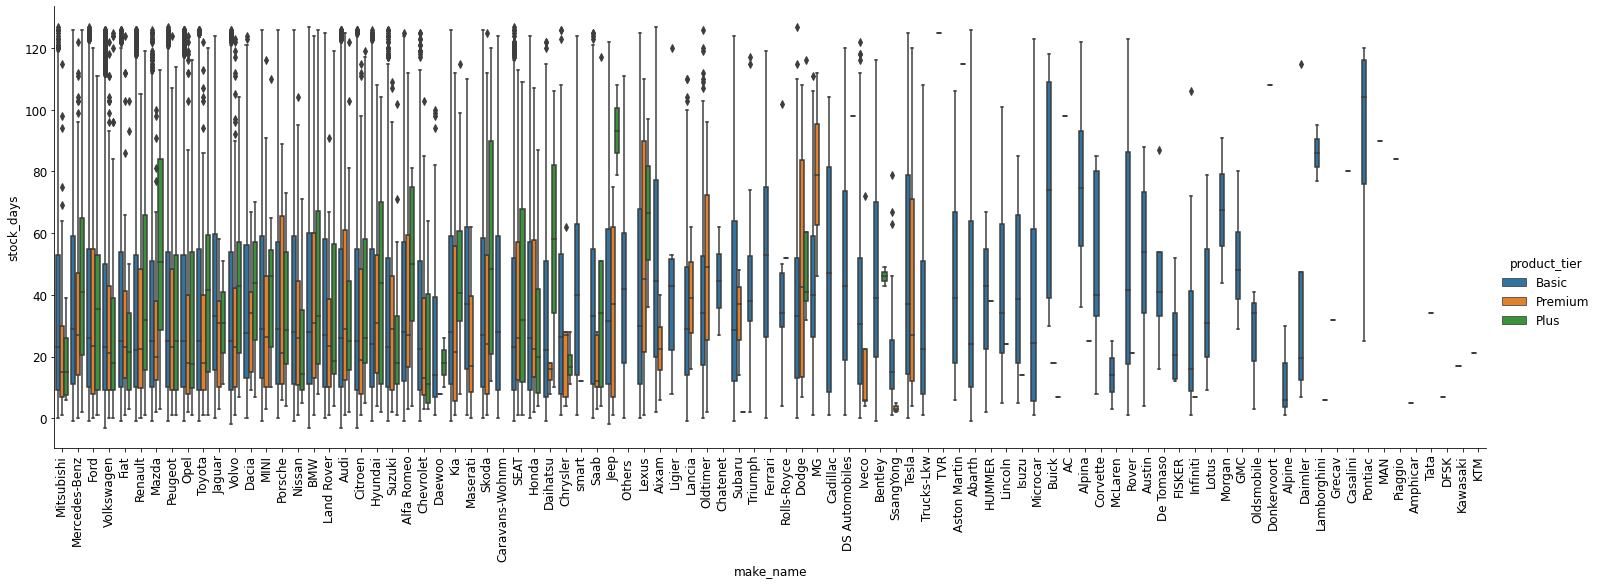

In [ ]:
sns.catplot( data = df, x='make_name', hue='product_tier', y='stock_days',  kind='box', height=7, aspect=3)
plt.xticks(rotation=90)
plt.show()

The graph above shows that the Plus articles have generally larger stock_days then the Basic articles. However this depends also on make_name. Basic products from right side have mostly larger stock_days. Similar can be seen on the box plot below with median stock_days of about 20 days for Premium and of about 30 stock days for Plus articles.

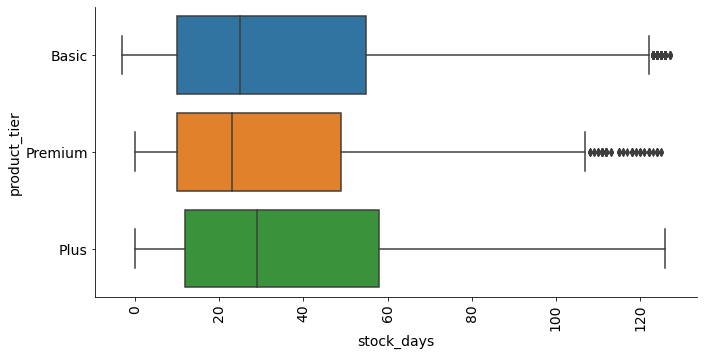

In [ ]:
sns.catplot( data = df, x='stock_days', y='product_tier', kind='box', height=5, aspect=2)
plt.xticks(rotation=90)
plt.show()

Based on data exploratory analysis the following conclusions can be drawn:  

1.   Most of data are skewed. Log transformation can be useful to address skewed data effectively.
2.   Product_tier is highly imbalanced with the majority class Basic, while Premium and Plus are minority classes. It is important to consider how to deal with an imbalanced dataset, for example: appropriate learning algorithms, data sampling, cost-sensitive solutions, appropriate performance metric.
3. In feature make_name the majority class is Volkswagen.
5.   Prediction of product_tier: data analysis shows some relations between the target product_tier and features such as first_registration_year / age,  detail_views, stock_days, price.





# **Predicting Product tier**

## **Preparing data for training**

In [ ]:
#Encoding categorical features. I chose label encoding because the number of categories in make_name is quite large and categories in product tier might be ordinal
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
label_encoder = LabelEncoder()
# Encode labels in columns 'product_tier' and 'make_name'. 
df['product_tier']= label_encoder.fit_transform(df['product_tier']) 
df['make_name']= label_encoder.fit_transform(df['make_name']) 

In [ ]:
df_log['product_tier']= label_encoder.fit_transform(df_log['product_tier']) 
df_log['make_name']= label_encoder.fit_transform(df_log['make_name']) 

Features created_date, deleted_date and created_year will be dropped, becasue they are not useful for predicting task.

In [ ]:
df = df.drop(['created_year', 'created_date', 'deleted_date'], axis=1)

In [ ]:
df.head()

article_id  product_tier  make_name  price  first_zip_digit  \
0   350625839             0         62  16750                5   
1   354412280             0         60  35950                4   
2   349572992             0         60  11950                3   
3   350266763             0         33   1750                6   
4   355688985             0         60  26500                3   

   first_registration_year  search_views  detail_views  stock_days       ctr  \
0                     2013        3091.0         123.0          30  0.039793   
1                     2015        3283.0         223.0          52  0.067926   
2                     1998        3247.0         265.0          51  0.081614   
3                     2003        1856.0          26.0         101  0.014009   
4                     2014         490.0          20.0          12  0.040816   

   age  
0    5  
1    3  
2   20  
3   15  
4    4

In [ ]:
df_log.head()

article_id  product_tier  make_name     price  first_zip_digit  \
0   350625839             0         62  4.224015                5   
1   354412280             0         60  4.555699                4   
2   349572992             0         60  4.077368                3   
3   350266763             0         33  3.243038                6   
4   355688985             0         60  4.423246                3   

   first_registration_year  search_views  detail_views  stock_days       ctr  \
0                 3.303844      3.490239      2.093422          30  0.016947   
1                 3.304275      3.516403      2.350248          52  0.028541   
2                 3.300595      3.511616      2.424882          51  0.034072   
3                 3.301681      3.268812      1.431364         101  0.006042   
4                 3.304059      2.691081      1.322219          12  0.017374   

        age  
0  0.903090  
1  0.778151  
2  1.361728  
3  1.255273  
4  0.845098

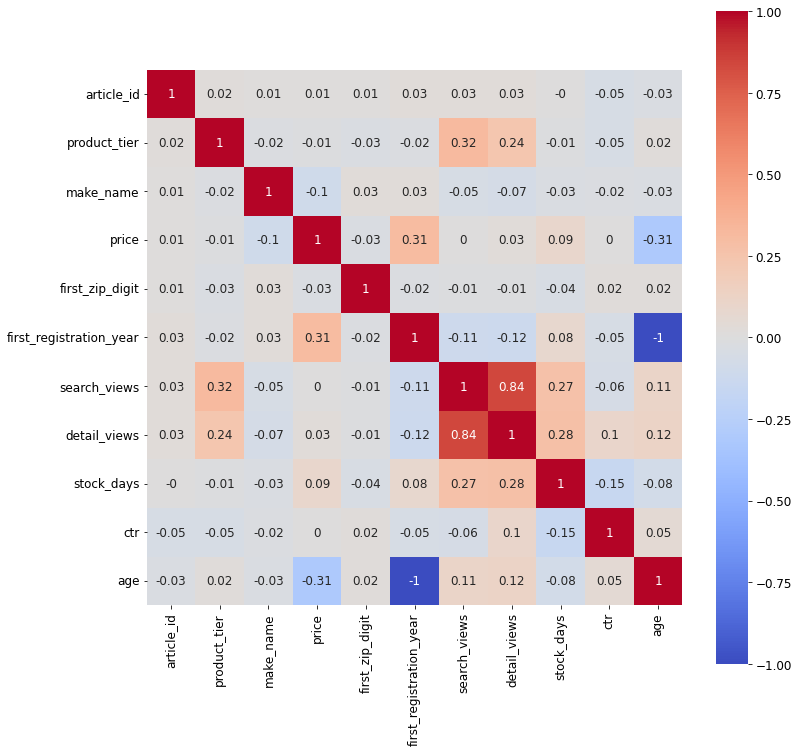

In [ ]:
c = np.round(df.corr(), 2)
plt.figure(figsize=(12,12))
sns.heatmap(c, annot=True, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.rcParams.update({'font.size':12})

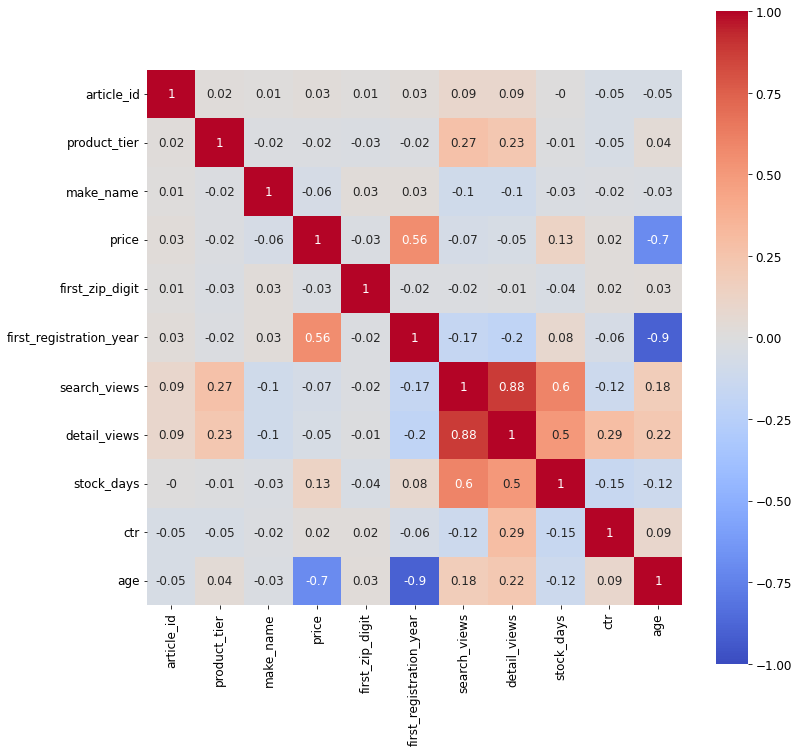

In [ ]:
#containing log features
c = np.round(df_log.corr(), 2)
plt.figure(figsize=(12,12))
sns.heatmap(c, annot=True, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.rcParams.update({'font.size':12})

The highest correlations to target product_tier have features search_views and detail_views with about 0.2-0.3 indicating weak positive linear relationships. Other features show no linear relationships. However, in data exploratory analysis we could detect some paterns to other features (first_registration_year, stock_days, prices), which could have nonlinear relationship.

The features "registration_year" and "age" are completely collinear, and the "age" is derived from the "registration year". Therefore, one of these features should be used. Since age is a more general characteristic and better fits the normal distribution after the log transformation, the feature registration_year is omitted in the next step. Feature 'article_id' will be also omitted.

In [168]:
#split data into X and y
X = df.loc[:, ['make_name', 'price', 'first_zip_digit', 'age','search_views', 'detail_views', 'ctr', 'stock_days']]
y = df['product_tier']

In [169]:
X_log = df_log.loc[:, ['make_name', 'price', 'first_zip_digit', 'age','search_views', 'detail_views', 'ctr', 'stock_days']]
y_log = df_log['product_tier']

In [170]:
# storing column names in cols
cols = X.columns

In [171]:
X.head()

make_name  price  first_zip_digit  age  search_views  detail_views  \
0         62  16750                5    5        3091.0         123.0   
1         60  35950                4    3        3283.0         223.0   
2         60  11950                3   20        3247.0         265.0   
3         33   1750                6   15        1856.0          26.0   
4         60  26500                3    4         490.0          20.0   

        ctr  stock_days  
0  0.039793          30  
1  0.067926          52  
2  0.081614          51  
3  0.014009         101  
4  0.040816          12

In [172]:
X_log.head()

make_name     price  first_zip_digit       age  search_views  detail_views  \
0         62  4.224015                5  0.903090      3.490239      2.093422   
1         60  4.555699                4  0.778151      3.516403      2.350248   
2         60  4.077368                3  1.361728      3.511616      2.424882   
3         33  3.243038                6  1.255273      3.268812      1.431364   
4         60  4.423246                3  0.845098      2.691081      1.322219   

        ctr  stock_days  
0  0.016947          30  
1  0.028541          52  
2  0.034072          51  
3  0.006042         101  
4  0.017374          12

In [173]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

In [174]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, train_size=0.7, test_size = 0.3, random_state=100)

In [175]:
from collections import Counter
Counter(y_train)

Counter({0: 52722, 1: 390, 2: 1659})

In [177]:
from collections import Counter
Counter(y_train_log)

Counter({0: 52722, 1: 390, 2: 1659})

In [176]:
Counter(y_test)

Counter({0: 22624, 2: 664, 1: 186})

In [178]:
Counter(y_test_log)

Counter({0: 22624, 2: 664, 1: 186})

## **Model Building, Training and Evaluation**

### **Dummy baseline**

I will first create a dummy baseline, representing a classifier which will always predict the majority class Basic. As scoring, I use accuracy, balanced accuracy (defined as the average accuracy obtained on each class individually) and F1 scores for multi-class classification. Macro F1-score: calculates F1-score for all classes individually and then average them, which is well suited for imbalanced cases. Micro F1-score: calculates F1-score of the aggregated contributions of all classes.

In [186]:
from sklearn.dummy import DummyClassifier
# define model
dummy_clf = DummyClassifier(strategy='most_frequent')
# define scoring
scoring = ['accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro']
# evaluate model
cv_result = cross_validate(dummy_clf, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score of a dummy classifier: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score of a dummy classifier: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score of a dummy classifier: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score of a dummy classifier: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score of a dummy classifier: 0.963
Balanced accuracy score of a dummy classifier: 0.333
F1 micro score of a dummy classifier: 0.963
F1 macro score of a dummy classifier: 0.327


In [187]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": [], "F1 macro score": []}

In [188]:
index += ['Dummy classifier']
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["F1 macro score"].append(cv_result["test_f1_macro"].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

Accuracy  Balanced accuracy  F1 macro score
Dummy classifier   0.96259           0.333333        0.326979

The dummy classifer achieves high accuracy of 0.96, because the majority of the data belongs to the Basic class. However, the dummy classifier cannot output other classes. This shows that the accuracy metric cannot be used for an imbalanced dataset. On the other hand, the balanced accuracy and F1 macro score show poor performance with just 0.33.

### **Logistic Regression**

No log-transformed features

In [189]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# define model
lr_clf = make_pipeline(StandardScaler(), LogisticRegression())
# evaluate model
cv_result = cross_validate(lr_clf, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.965
Balanced accuracy score: 0.381
F1 micro score: 0.965
F1 macro score: 0.406


In [190]:
index = ["Logistic regression"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-190-b27e94af0066>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  F1 macro score
Dummy classifier     0.962590           0.333333        0.326979
Logistic regression  0.964543           0.381294        0.406340

Logistic regression achieves slight improvement in the balanced accuracy for ~0.04 and in F1 macro score  for ~0.07.

Let's now try Logistic regression with balanced class weights. Here, the class weights of the majority and manority classes are modified so that the classes are assigned weights that are inversely proportional to the their respective frequencies.

In [191]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
# define model
lrbw_clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
# evaluate model
cv_result = cross_validate(lrbw_clf, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.866
Balanced accuracy score: 0.638
F1 micro score: 0.866
F1 macro score: 0.478


In [192]:
index = ["Logistic regression, balanced class weights"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-192-b2d63444bba2>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                             0.962590           0.333333   
Logistic regression                          0.964543           0.381294   
Logistic regression, balanced class weights  0.865951           0.637934   

                                             F1 macro score  
Dummy classifier                                   0.326979  
Logistic regression                                0.406340  
Logistic regression, balanced class weights        0.478262

Logistic regresion with balanced weights resulted in a more significant improvement in balanced accuracy with a score of 0.56. The F1 macro score, which takes into account both the precision and recall, shows a bit less improvement achieving a score of 0.42.

### **Logistic Regression with log-features**

with log-transformed features

In [193]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# define model
lr_clf = make_pipeline(StandardScaler(), LogisticRegression())
# evaluate model
cv_result = cross_validate(lr_clf, X_train_log, y_train_log, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.969
Balanced accuracy score: 0.445
F1 micro score: 0.969
F1 macro score: 0.481


In [194]:
index = ["Logistic regression log"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-194-ab317d960bfb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                             0.962590           0.333333   
Logistic regression                          0.964543           0.381294   
Logistic regression, balanced class weights  0.865951           0.637934   
Logistic regression log                      0.969035           0.445314   

                                             F1 macro score  
Dummy classifier                                   0.326979  
Logistic regression                                0.406340  
Logistic regression, balanced class weights        0.478262  
Logistic regression log                            0.481152

Logistic regression with logarithmic features achieves improvement over logistic regression without logarithmic features in balanced accuracy and F1 macro score of about 0.07.

Let's now try again Logistic regression with balanced class weights.

In [196]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
# define model
lrbw_clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
# evaluate model
cv_result = cross_validate(lrbw_clf, X_train_log, y_train_log, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.774
Balanced accuracy score: 0.648
F1 micro score: 0.774
F1 macro score: 0.444


In [197]:
index = ["Logistic regression log, balanced class weights"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-197-34f27bc667a2>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                                 0.962590           0.333333   
Logistic regression                              0.964543           0.381294   
Logistic regression, balanced class weights      0.865951           0.637934   
Logistic regression log                          0.969035           0.445314   
Logistic regression log, balanced class weights  0.774333           0.647753   

                                                 F1 macro score  
Dummy classifier                                       0.326979  
Logistic regression                                    0.406340  
Logistic regression, balanced class weights            0.478262  
Logistic regression log                                0.481152  
Logistic regression log, balanced class weights        0.444046

The logistic regression with balanced weights and logarithmic features resulted in worse performance in accuracy and F1 macro score than the logistic regression with balanced weights and non-logarithmic features, while the balanced accuracy was slightly improved (~0.01).

### **Random Forest**

I will try next multi-tree classifier. With this type of classifier, it is not needed to scale the numerical data. Random forest is proven to be powerful algorithm for classification. It is quite fast / computational efficient, fast to optimize and it can be used for multi-class classification. Also, using a decision tree-based algorithm, the contribution of the features to the model prediction can be easily estimated to provide an insight into what the model has learned and which predictors are important. The dataset is not huge to require deep learning, so the problem could be solved with classical machine learning algorithms.

In [198]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
# evaluate model
cv_result = cross_validate(rf_clf, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.972
Balanced accuracy score: 0.472
F1 micro score: 0.972
F1 macro score: 0.508


In [199]:
index = ["Random forest"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-199-aeee68e6723a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                                 0.962590           0.333333   
Logistic regression                              0.964543           0.381294   
Logistic regression, balanced class weights      0.865951           0.637934   
Logistic regression log                          0.969035           0.445314   
Logistic regression log, balanced class weights  0.774333           0.647753   
Random forest                                    0.971627           0.471708   

                                                 F1 macro score  
Dummy classifier                                       0.326979  
Logistic regression                                    0.406340  
Logistic regression, balanced class weights            0.478262  
Logistic regression log                                0.481152  
Logistic regression log, balanced class weights        0.444046  
Random forest                                          0.508124

Random Forest improves the scores compared to logistic regression and logistic regression with balanced class weights. However, the logistic regression with balanced class weights still has higher balanced accuracy. We will see if Random Forest with balanced class weights can provide further improvements.

In [200]:
rf_clf_2 = RandomForestClassifier(class_weight='balanced')
# evaluate model
cv_result = cross_validate(rf_clf_2, X_train, y_train, cv=5, scoring=scoring)
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.971
Balanced accuracy score: 0.445
F1 micro score: 0.971
F1 macro score: 0.487


In [201]:
index = ["Random forest, balanced class weights"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-201-e9601a1143ae>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                                 0.962590           0.333333   
Logistic regression                              0.964543           0.381294   
Logistic regression, balanced class weights      0.865951           0.637934   
Logistic regression log                          0.969035           0.445314   
Logistic regression log, balanced class weights  0.774333           0.647753   
Random forest                                    0.971627           0.471708   
Random forest, balanced class weights            0.970550           0.445457   

                                                 F1 macro score  
Dummy classifier                                       0.326979  
Logistic regression                                    0.406340  
Logistic regression, balanced class weights            0.478262  
Logistic regression log                                0.481152  
Logistic regression log, balanced class weights        0.444046  
Random forest                                          0.508124  
Random forest, balanced class weights                  0.487093

Results show that Random forest with balanced class weights caused a slight degradation of results compared to the "normal" Random forest model. Let's now try Balanced Random forest classifier, which randomly under-samples each boostrap sample to balance it.

In [ ]:
#Random forest method applying random-under data sampling to balance the different bootstraps
from imblearn.ensemble import BalancedRandomForestClassifier
rfb_clf = BalancedRandomForestClassifier()
# evaluate model
cv_result = cross_validate(rfb_clf, X_train, y_train, cv=5, scoring=scoring)

In [203]:
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.784
Balanced accuracy score: 0.694
F1 micro score: 0.784
F1 macro score: 0.464


In [204]:
index = ["Balanced Random forest"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-204-89ecbef765bd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                                 0.962590           0.333333   
Logistic regression                              0.964543           0.381294   
Logistic regression, balanced class weights      0.865951           0.637934   
Logistic regression log                          0.969035           0.445314   
Logistic regression log, balanced class weights  0.774333           0.647753   
Random forest                                    0.971627           0.471708   
Random forest, balanced class weights            0.970550           0.445457   
Balanced Random forest                           0.784083           0.694316   

                                                 F1 macro score  
Dummy classifier                                       0.326979  
Logistic regression                                    0.406340  
Logistic regression, balanced class weights            0.478262  
Logistic regression log                                0.481152  
Logistic regression log, balanced class weights        0.444046  
Random forest                                          0.508124  
Random forest, balanced class weights                  0.487093  
Balanced Random forest                                 0.464020

Balanced Random Forest achieves the highest balanced accuracy of ~0.7 and a F1 score of 0.5. The overall accuracy has also decreased to ~0.8. However, compared to the logistic regression with balanced class weights, there is an improvement in balanced accuracy, but the overall accuracy and F1 macro score are slightly lower.

Let's now try the Balanced Random forest with log features.

In [ ]:
#Random forest method applying random-under data sampling to balance the different bootstraps
from imblearn.ensemble import BalancedRandomForestClassifier
rfb_clf_log = BalancedRandomForestClassifier()
# evaluate model
cv_result = cross_validate(rfb_clf_log, X_train_log, y_train_log, cv=5, scoring=scoring)

In [206]:
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.784
Balanced accuracy score: 0.695
F1 micro score: 0.784
F1 macro score: 0.467


In [207]:
index = ["Balanced Random forest log"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-207-3c47a3674ade>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                                 0.962590           0.333333   
Logistic regression                              0.964543           0.381294   
Logistic regression, balanced class weights      0.865951           0.637934   
Logistic regression log                          0.969035           0.445314   
Logistic regression log, balanced class weights  0.774333           0.647753   
Random forest                                    0.971627           0.471708   
Random forest, balanced class weights            0.970550           0.445457   
Balanced Random forest                           0.784083           0.694316   
Balanced Random forest log                       0.783681           0.695363   

                                                 F1 macro score  
Dummy classifier                                       0.326979  
Logistic regression                                    0.406340  
Logistic regression, balanced class weights            0.478262  
Logistic regression log                                0.481152  
Logistic regression log, balanced class weights        0.444046  
Random forest                                          0.508124  
Random forest, balanced class weights                  0.487093  
Balanced Random forest                                 0.464020  
Balanced Random forest log                             0.466516

There is not much difference between the last two models. The Balanced Random Forest performs superior than other algortithm taking into account all balanced accuracy and F1 macro score. Therefore, the balanced Random forest with non-logarithmic features will be used for fine-tunning.

### Hyperparameters tunning

Now I will do some simple fine-tuning for the Balanced Random forest to try to further improve its performance.

In [ ]:
#parameters tuning
max_depth = [5, 10, 15, 20, None]

for count in max_depth:
    cv_result = cross_validate(BalancedRandomForestClassifier(max_depth = count), X_train, y_train, cv=5, scoring=scoring)
    print(f'For max depth: {count}')
    print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
    print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")

For max depth: 5
Accuracy score: 0.734
Balanced accuracy score: 0.649
For max depth: 10
Accuracy score: 0.773
Balanced accuracy score: 0.687
For max depth: 15
Accuracy score: 0.778
Balanced accuracy score: 0.680
For max depth: 20
Accuracy score: 0.779
Balanced accuracy score: 0.683
For max depth: None
Accuracy score: 0.781
Balanced accuracy score: 0.683


In [ ]:
#parameters tuning
estimators = [100, 200, 300, 400, 500, 750, 1000]

for count in estimators:
    cv_result = cross_validate(BalancedRandomForestClassifier(n_estimators = count), X_train, y_train, cv=5, scoring=scoring)
    print(f'For estimators: {count}')
    print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
    print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
    print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

For estimators: 100
Accuracy score: 0.782
Balanced accuracy score: 0.690
F1 macro score: 0.467
For estimators: 200
Accuracy score: 0.781
Balanced accuracy score: 0.689
F1 macro score: 0.467
For estimators: 300
Accuracy score: 0.782
Balanced accuracy score: 0.694
F1 macro score: 0.468
For estimators: 400
Accuracy score: 0.782
Balanced accuracy score: 0.687
F1 macro score: 0.468
For estimators: 500
Accuracy score: 0.783
Balanced accuracy score: 0.689
F1 macro score: 0.468
For estimators: 750
Accuracy score: 0.783
Balanced accuracy score: 0.692
F1 macro score: 0.468
For estimators: 1000
Accuracy score: 0.783
Balanced accuracy score: 0.693
F1 macro score: 0.469


In [ ]:
#parameters tuning
estimators = [1500, 2000, 2500, 3000, 5000]

for count in estimators:
    cv_result = cross_validate(BalancedRandomForestClassifier(n_estimators = count), X_train, y_train, cv=5, scoring=scoring)
    print(f'For estimators: {count}')
    print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
    print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
    print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

For estimators: 1500
Accuracy score: 0.783
Balanced accuracy score: 0.691
F1 macro score: 0.469
For estimators: 2000
Accuracy score: 0.782
Balanced accuracy score: 0.693
F1 macro score: 0.469
For estimators: 2500
Accuracy score: 0.782
Balanced accuracy score: 0.692
F1 macro score: 0.468
For estimators: 3000
Accuracy score: 0.782
Balanced accuracy score: 0.692
F1 macro score: 0.469
For estimators: 5000
Accuracy score: 0.782
Balanced accuracy score: 0.694
F1 macro score: 0.469


In [ ]:
#Random forest method applying random-under data sampling to balance the different bootstraps
from imblearn.ensemble import BalancedRandomForestClassifier
rfb_clf = BalancedRandomForestClassifier(n_estimators=1000)
# evaluate model
cv_result = cross_validate(rfb_clf, X_train, y_train, cv=5, scoring=scoring)

In [212]:
# summarize performance
print(f"Accuracy score: {cv_result['test_accuracy'].mean():.3f}")
print(f"Balanced accuracy score: {cv_result['test_balanced_accuracy'].mean():.3f}")
print(f"F1 micro score: {cv_result['test_f1_micro'].mean():.3f}")
print(f"F1 macro score: {cv_result['test_f1_macro'].mean():.3f}")

Accuracy score: 0.786
Balanced accuracy score: 0.701
F1 micro score: 0.786
F1 macro score: 0.471


In [218]:
index = ["Balanced Random forest tuned"]
scores["Accuracy"]=cv_result["test_accuracy"].mean()
scores["Balanced accuracy"]=cv_result["test_balanced_accuracy"].mean()
scores["F1 macro score"]=cv_result["test_f1_macro"].mean()
df2 = pd.DataFrame(scores, index=index)
df_scores = df_scores.append(df2)
df_scores

<ipython-input-218-64c528df399c>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(df2)


Accuracy  Balanced accuracy  \
Dummy classifier                                 0.962590           0.333333   
Logistic regression                              0.964543           0.381294   
Logistic regression, balanced class weights      0.865951           0.637934   
Logistic regression log                          0.969035           0.445314   
Logistic regression log, balanced class weights  0.774333           0.647753   
Random forest                                    0.971627           0.471708   
Random forest, balanced class weights            0.970550           0.445457   
Balanced Random forest                           0.784083           0.694316   
Balanced Random forest log                       0.783681           0.695363   
Balanced Random forest tuned                     0.786128           0.700629   

                                                 F1 macro score  
Dummy classifier                                       0.326979  
Logistic regression                                    0.406340  
Logistic regression, balanced class weights            0.478262  
Logistic regression log                                0.481152  
Logistic regression log, balanced class weights        0.444046  
Random forest                                          0.508124  
Random forest, balanced class weights                  0.487093  
Balanced Random forest                                 0.464020  
Balanced Random forest log                             0.466516  
Balanced Random forest tuned                           0.470501

The tuned model offers slight improvements in accuracy, balanced accuracy and F1 macro rating.

In [ ]:
model_rfb_clf=rfb_clf.fit(X_train, y_train)
y_pred_rfb_train = model_rfb_clf.predict(X_train)

In [214]:
## Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred_rfb_train, labels=[0, 1, 2])

array([[41857,  9116,  1749],
       [    0,   390,     0],
       [  109,   192,  1358]])

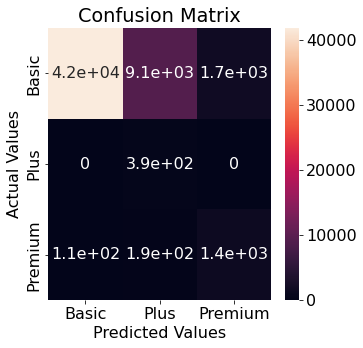

In [216]:
#Plotting the confusion matrix for Balanced Random forest
cm_rfb = confusion_matrix(y_train, y_pred_rfb_train)
cm_df_rfb = pd.DataFrame(cm_rfb, index = ['Basic','Plus','Premium'], columns = ['Basic','Plus','Premium'])
#Balanced Random forest tuned
plt.figure(figsize=(5,5))
sns.heatmap(cm_df_rfb, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

The confusion matrix for the Balanced Random forest model on training data has the highest number of true positives in each row. For minority class Plus are only true positives, while for class Premium about 20% of data are false predictions. Also, about 25% of Basic class data were predicted as Plus class on training dataset. 

### Learning curves

Let's now plot learning curves for the final final Balanced Random forest model.

In [ ]:
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, train_sizes, cv, scoring): 
  train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, train_sizes = train_sizes, cv = cv, scoring = scoring)
  train_scores_mean = train_scores.mean(axis = 1)
  validation_scores_mean = validation_scores.mean(axis = 1)
  
  plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')
  plt.ylabel('Accuracy', fontsize = 16)
  plt.xlabel('Training set size', fontsize = 16)
  title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
  plt.title(title, fontsize = 18, y = 1.03)
  plt.legend() 
  plt.rcParams.update({'font.size': 16})
  plt.ylim(0.4, 1)

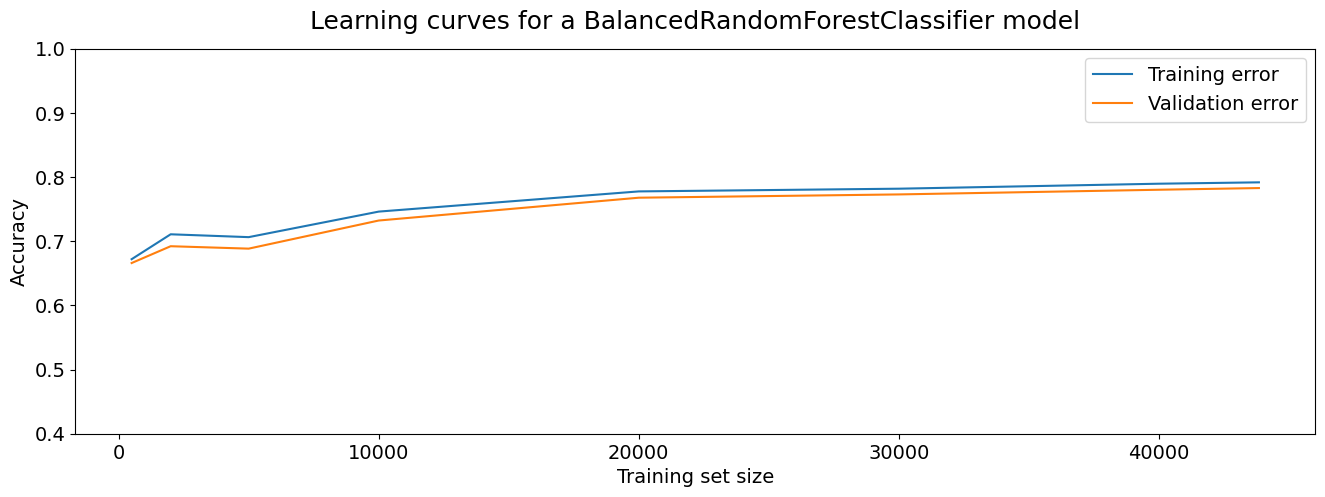

In [ ]:
plt.figure(figsize = (16,5))
train_sizes = [1, 100, 500, 2000, 5000, 10000, 20000, 30000, 40000, 43845]
learning_curves(model_rfb_clf, X_train, y_train, train_sizes, 5, 'accuracy')

The learning curves above show high overall accuracy for both the training and validation datasets, which increases as the training set size increases, and after at a dataset size of ~30000 and more, the accuracies are almost the same and become constant.

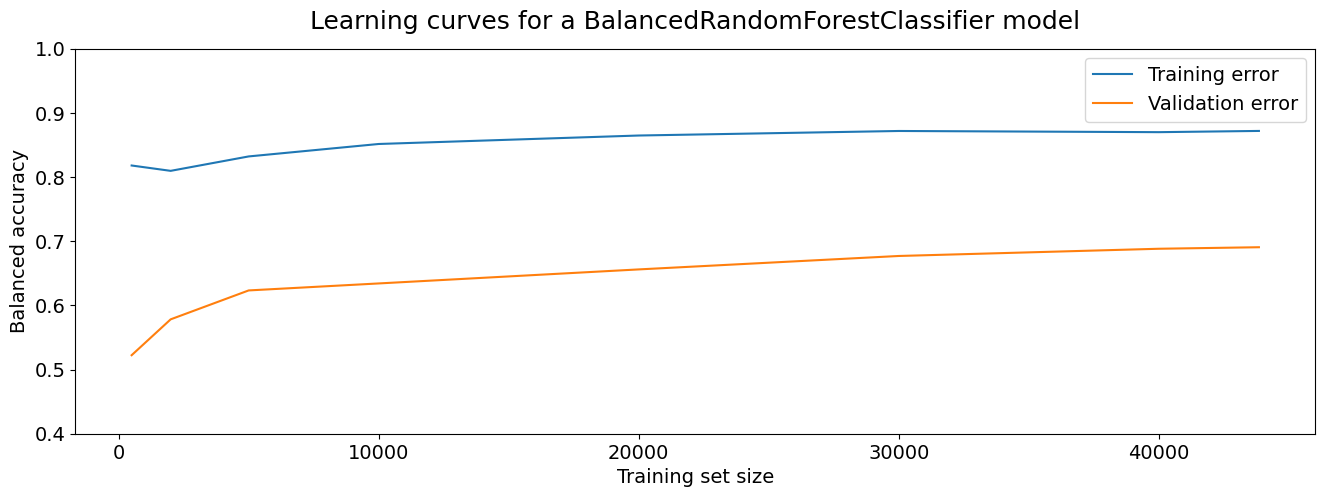

In [ ]:
plt.figure(figsize = (16,5))
train_sizes = [1, 100, 500, 2000, 5000, 10000, 20000, 30000, 40000, 43845]
learning_curves(model_rfb_clf, X_train, y_train, train_sizes, 5, 'balanced_accuracy')

The learning curves for the balanced accuracy show a high training accuracy (>0.8) as soon as the data set size increases to 5000 and more.  The validation curve increases from ~0.5 at beginning (dataset size of 1) to ~0.65 at a dataset size of 100000. After that, the line continues to rise steadily. The difference between the training curve and the validation curve is about 0.15 at the end.

### Impurity-based feature importance

Now I will plot impurity-based feature importance to check impact of features on the model output for Balanced Random Forest tuned model.

In [219]:
features = cols

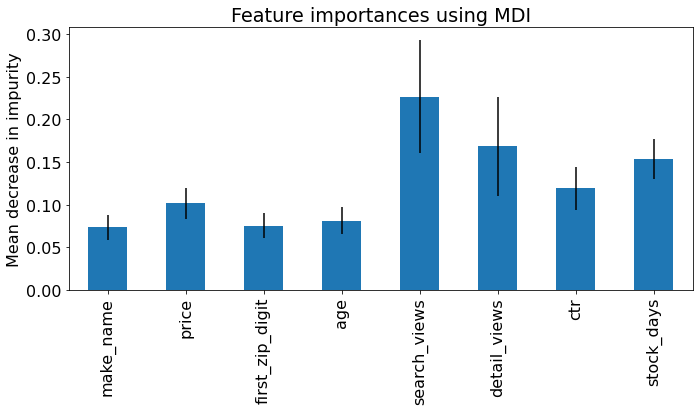

In [232]:
importances = model_rfb_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rfb_clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.rcParams ['figure.figsize'] =  [10,6]

Plot shows the highest importance for input features such as search_views, detail_views, stock_days and ctr.

## **Final Model Evaluation (Test data)**

For final testing, I choose Balanced Random Forest tuned model.

In [233]:
## Predict your test set on the trained model Balanced Random forest
y_pred_rfb = model_rfb_clf.predict(X_test)

### Accuracy / F1 score

In [234]:
#Balanced Random forest
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
print(f"Accuracy score: {accuracy_score(y_test, y_pred_rfb):.2f}")
print(f"Accuracy score balanced: {balanced_accuracy_score(y_test, y_pred_rfb):.2f}")
print(f"F1 micro score: {f1_score (y_test, y_pred_rfb, average='micro'):.2f}")
print(f"F1 macro score: {f1_score (y_test, y_pred_rfb, average='macro'):.2f}")

Accuracy score: 0.78
Accuracy score balanced: 0.66
F1 micro score: 0.78
F1 macro score: 0.46


Test results show balanced accuracy score of 0.66, while the F1 macro score is 0.46.

### Precision/Recall

In [235]:
#Balanced Random forest
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

print(f"Precision score macro: {precision_score(y_test, y_pred_rfb, average='macro'):.2f}")
print(f"Precision score micro: {precision_score(y_test, y_pred_rfb, average='micro'):.2f}")
print(f"Recall score macro: {recall_score(y_test, y_pred_rfb, average='macro'):.2f}")
print(f"Recall score micro: {recall_score(y_test, y_pred_rfb, average='micro'):.2f}")

Precision score macro: 0.46
Precision score micro: 0.78
Recall score macro: 0.66
Recall score micro: 0.78


Higher recall suggests having less false negative, i.e. a large fraction of truly positive elements are captured. Higher precision suggests that a model has less false positives, and thus providing more relevant results.

### Confusion matrix

In [236]:
#Balanced Random forest
## Calculate the confusion matrix
confusion_matrix(y_test, y_pred_rfb, labels=[0, 1, 2])

array([[17885,  3994,   745],
       [   39,   100,    47],
       [   64,   168,   432]])

Let's visualize the confusion matrices below.

In [237]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm_rfb = confusion_matrix(y_test, y_pred_rfb)

In [238]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_rfb = pd.DataFrame(cm_rfb, index = ['Basic','Plus','Premium'], columns = ['Basic','Plus','Premium'])

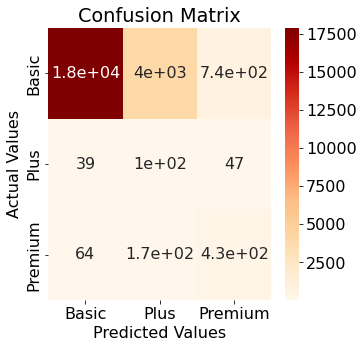

In [240]:
#Plotting the confusion matrix for Balanced Random forest
#Balanced Random forest tuned
plt.figure(figsize=(5,5))
sns.heatmap(cm_df_rfb, annot=True, cmap= 'OrRd')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

The confusion matrix for the balanced random forest model for the test data set has the highest number of correct-positive predictions in each row. However, for the Basic and Premium classes, there are a large number of false predictions, e.g., Basic is predicted to be Plus or Premium is predicted to be Plus. The number of false predictions for the Plus category is significantly lower.

### Permutation feature importance

Permutation feature importance overcomes the limitations of impurity-based feature importance: it has no bias towards high-cardinality features and can be computed on a hold-out test set.

In [241]:
# Balanced Random forest tuned
# Permutation feature importance on train dataset
from sklearn.inspection import permutation_importance
result = permutation_importance(model_rfb_clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=features)

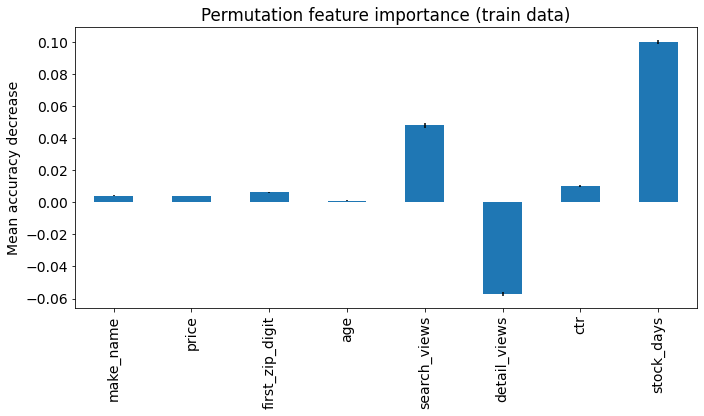

In [245]:
#Permutation feature importance on train dataset
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Permutation feature importance (train data)")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.rcParams.update({'font.size': 14})
plt.show()

In [246]:
# Balanced Random forest tuned
# Permutation feature importance on test dataset
result = permutation_importance(model_rfb_clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=features)

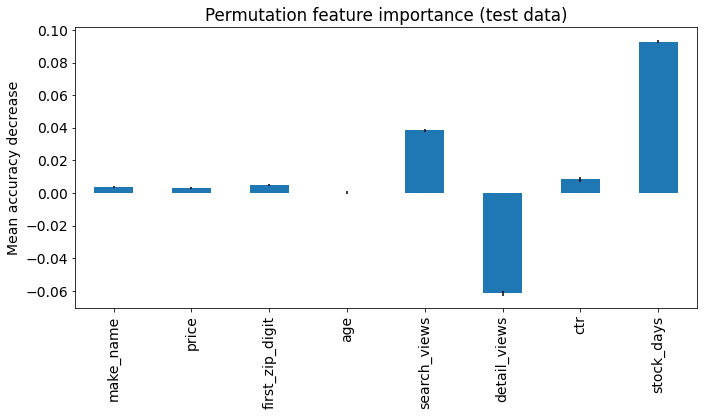

In [249]:
#Permutation feature importance on test dataset
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Permutation feature importance (test data)")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.rcParams.update({'font.size': 14})
plt.show()

The permutation feature importance plot on the training and test datasets shows the highest importance of the feature 'stock_days'. Other important features are 'detail_views' and 'search_views'. It is interesting to see that the feature 'age' has almost no contribution in the test data, while it has a low contribution in the training data.

## **Conclusion**

*   Product tier classes are highly imbalanced, making it difficult to predict minority classes. Using techniques to balance dataset/classes led to significant improvement in learning and generalizing, resulting in more balanced accuracy and higher F1 macro score. 
* Using methods of balanced boostrap sampling with Random forest led to better predictions of minority classes. There are still false predictions that can be further adressed to potentially improve accuracy.
* Recall macro score is higher than precision, which means that there are fewer false negative, i.e., a large fraction of true positive are captured, but the model has more false positives.
* Final balanced accuracy is 0.70.
*  The permutation analysis of feature importance shows that "stock_days", "search_views" and "detail_views" are the most important predictors for the final Balanced Random Forest model.